In [40]:
import numpy as np
import pandas as pd
import os
from data_generators.Clinic.Clinic import ClinicGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import FeatureAgglomeration
from sklearn.inspection import permutation_importance
import umap

In [41]:

def create_gene_dataset_with_disease_effect(
    n_samples: int = 100,
    n_genes: int = 15000,
    num_disease_genes: int = 15000,
    gene_type: str = "Microarray",
    disease_effect_type: str = "additive_shift",
    disease_effect_value: float = 1.5,
    control_disease_ratio: float = 0.5
):
    """
    Generates a gene expression dataset where a specified number of genes
    are correlated with a disease state.

    Args:
        n_samples (int): Number of patient samples to generate.
        n_genes (int): Total number of genes in the dataset.
        num_disease_genes (int): Number of genes that will show a disease effect.
        gene_type (str): Type of gene data to generate ("Microarray" or "RNA-Seq").
        disease_effect_type (str): Type of effect for disease genes
                                   ("additive_shift" for Microarray, "fold_change" for RNA-Seq).
        disease_effect_value (float or list): Magnitude of the disease effect. Can be a float or a [min, max] range.
        control_disease_ratio (float): The ratio of control to disease patients.
    """
    print(f"Starting gene dataset generation with {n_genes} genes, {num_disease_genes} disease-correlated.")

    # Initialize the ClinicGenerator
    generator = ClinicGenerator(seed=42)

    # Generate demographic data to get the groups
    demographic_df, raw_demographic_data = generator.generate_demographic_data(
        n_samples=n_samples,
        control_disease_ratio=control_disease_ratio
    )

    # Define the disease effect using the new configuration object
    disease_effects_config = [
        {
            'name': 'disease_effect',
            'indices': list(range(num_disease_genes)),
            'effect_type': disease_effect_type,
            'effect_value': disease_effect_value
        }
    ]

    # Generate gene data using the new config
    df_genes = generator.generate_gene_data(
        n_genes=n_genes,
        gene_type=gene_type,
        demographic_df=demographic_df,
        demographic_id_col=demographic_df.index.name,
        raw_demographic_data=raw_demographic_data,
        disease_effects_config=disease_effects_config
    )

    # Add the 'Grupo' column to the dataframe
    df_genes['Grupo'] = demographic_df['Grupo']

    # Convert 'Grupo' column to binary (0 for Control, 1 for Enfermedad)
    df_genes['Grupo'] = df_genes['Grupo'].map({'Control': 0, 'Enfermedad': 1})

    print("Generation complete.")
    return df_genes

In [42]:
def create_minimal_effect_gene_dataset(
    n_samples: int = 100,
    n_genes: int = 15000,
    num_disease_genes: int = 10,
    num_correlated_genes: int = 10,
    correlation_value: float = 0.8,
    gene_type: str = "Microarray",
    disease_effect_type: str = "additive_shift",
    disease_effect_value: float = 0.0, # Minimal effect
    control_disease_ratio: float = 0.5
):
    """
    Generates a gene expression dataset where a subset of genes are correlated with each other,
    and a subset of genes have a minimal correlation with a disease state.

    Args:
        n_samples (int): Number of patient samples to generate.
        n_genes (int): Total number of genes in the dataset.
        num_disease_genes (int): Number of genes that will show a disease effect.
        num_correlated_genes (int): Number of genes in the correlated group.
        correlation_value (float): Correlation value for genes within the group.
        gene_type (str): Type of gene data to generate ("Microarray" or "RNA-Seq").
        disease_effect_type (str): Type of effect for disease genes
                                   ("additive_shift" for Microarray, "fold_change" for RNA-Seq).
        disease_effect_value (float or list): Magnitude of the disease effect. Can be a float or a [min, max] range.
    """
    print(f"Starting gene dataset generation with {n_genes} genes...")

    # Initialize the ClinicGenerator
    generator = ClinicGenerator(seed=42)

    # Generate demographic data to get the groups
    demographic_df, raw_demographic_data = generator.generate_demographic_data(
        n_samples=n_samples,
        control_disease_ratio=control_disease_ratio
    )

    # --- 1. Define correlation matrix ---
    correlation_matrix = np.identity(n_genes)
    if num_correlated_genes > 0 and correlation_value != 0:
        print(f"Introducing correlation for a group of {num_correlated_genes} genes.")
        corr_block = np.full((num_correlated_genes, num_correlated_genes), correlation_value)
        np.fill_diagonal(corr_block, 1.0)
        # Place the block at the beginning of the matrix
        correlation_matrix[0:num_correlated_genes, 0:num_correlated_genes] = corr_block

    # Define the disease effect using the new configuration object
    disease_effects_config = [
        {
            'name': 'disease_effect',
            'indices': list(range(num_disease_genes)),
            'effect_type': disease_effect_type,
            'effect_value': disease_effect_value
        }
    ]

    # Generate gene data
    df_genes = generator.generate_gene_data(
        n_genes=n_genes,
        gene_type=gene_type,
        demographic_df=demographic_df,
        demographic_id_col=demographic_df.index.name,
        raw_demographic_data=raw_demographic_data,
        gene_correlations=correlation_matrix,
        disease_effects_config=disease_effects_config
    )

    # Add the 'Grupo' column to the dataframe
    df_genes['Grupo'] = demographic_df['Grupo']

    # Convert 'Grupo' column to binary (0 for Control, 1 for Enfermedad)
    df_genes['Grupo'] = df_genes['Grupo'].map({'Control': 0, 'Enfermedad': 1})

    print("Generation complete.")
    return df_genes

In [43]:
def create_split_gene_correlated_dataset(
    n_samples: int = 100,
    n_genes: int = 50,
    num_disease_genes_1: int = 20,
    num_disease_genes_2: int = 10,
    corr_group_1: float = 0.6,
    corr_group_2: float = 0.7,
    gene_type: str = "Microarray",
    disease_effect_type: str = "additive_shift",
    disease_effect_type_2: str = None, 
    disease_effect_value: float = 1.5,
    disease_effect_value_2: float = None, 
    num_patients_subtype_1: int = 20, # New: Number of patients in the first disease subtype
    control_disease_ratio: float = 0.5
):
    """
    Generates a gene expression dataset with two independent, correlated gene modules.
    It now supports creating disease subtypes, where different subsets of disease patients
    have different molecular effects.

    Args:
        n_samples (int): Number of patient samples to generate.
        n_genes (int): Total number of genes in the dataset.
        num_disease_genes_1 (int): Number of genes in the first group.
        num_disease_genes_2 (int): Number of genes in the second group.
        corr_group_1 (float): Correlation value for genes within the first group.
        corr_group_2 (float): Correlation value for genes within the second group.
        gene_type (str): Type of gene data to generate ("Microarray" or "RNA-Seq").
        disease_effect_type (str): Type of effect for the first group of disease genes.
        disease_effect_type_2 (str, optional): Type of effect for the second group. Defaults to `disease_effect_type`.
        disease_effect_value (float or list): Magnitude of the disease effect for the first group.
        disease_effect_value_2 (float or list, optional): Magnitude of the disease effect for the second group.
        num_patients_subtype_1 (int): Number of disease patients to assign to the first subtype (affecting module 1).
    """
    total_affected_genes = num_disease_genes_1 + num_disease_genes_2
    if total_affected_genes > n_genes:
        raise ValueError("The sum of disease genes cannot be greater than the total number of genes.")

    # Default for second effect type is the same as the first
    if disease_effect_type_2 is None:
        disease_effect_type_2 = disease_effect_type

    if disease_effect_value_2 is None:
        if isinstance(disease_effect_value, list):
            if disease_effect_type_2 == 'fold_change':
                 disease_effect_value_2 = [1/x for x in reversed(disease_effect_value)]
            else:
                 disease_effect_value_2 = [-x for x in reversed(disease_effect_value)]
        else:
            if disease_effect_type_2 == 'fold_change':
                disease_effect_value_2 = 1 / disease_effect_value if disease_effect_value != 0 else 1
            else:
                disease_effect_value_2 = -disease_effect_value

    print(f"Starting gene dataset generation with {n_genes} genes...")

    generator = ClinicGenerator(seed=42)

    demographic_df, raw_demographic_data = generator.generate_demographic_data(
        n_samples=n_samples,
        control_disease_ratio=control_disease_ratio
    )

    # --- 1. Define Gene Modules and Block-Diagonal Correlation Matrix ---
    module_1_indices = list(range(num_disease_genes_1))
    module_2_start_index = num_disease_genes_1
    module_2_indices = list(range(module_2_start_index, module_2_start_index + num_disease_genes_2))

    correlation_matrix = np.identity(n_genes)

    def fill_block(matrix, indices, corr_value):
        for i in indices:
            for j in indices:
                if i != j:
                    matrix[i, j] = corr_value

    if num_disease_genes_1 > 0:
        fill_block(correlation_matrix, module_1_indices, corr_group_1)

    if num_disease_genes_2 > 0:
        fill_block(correlation_matrix, module_2_indices, corr_group_2)

    # --- 2. Define Disease Heterogeneity (Subtypes and Effects) ---
    print(f"Defining disease subtypes: {num_patients_subtype_1} patients for module 1, remainder for module 2.")
    disease_effects_config = {
        'patient_subgroups': [
            {
                'name': 'Subtype_A',
                'count': num_patients_subtype_1,
                'apply_effects': ['module_1_effect']
            },
            {
                'name': 'Subtype_B',
                'remainder': True,
                'apply_effects': ['module_2_effect']
            }
        ],
        'effects': {
            'module_1_effect': {
                'indices': module_1_indices,
                'effect_type': disease_effect_type,
                'effect_value': disease_effect_value
            },
            'module_2_effect': {
                'indices': module_2_indices,
                'effect_type': disease_effect_type_2,
                'effect_value': disease_effect_value_2
            }
        }
    }

    # --- 3. Generate all gene data in a single call ---
    print("Generating gene data with disease subtypes...")
    df_genes_final = generator.generate_gene_data(
        n_genes=n_genes,
        gene_type=gene_type,
        demographic_df=demographic_df,
        demographic_id_col=demographic_df.index.name,
        raw_demographic_data=raw_demographic_data,
        gene_correlations=correlation_matrix,
        disease_effects_config=disease_effects_config,
        n_samples=n_samples
    )

    df_genes_final['Grupo'] = demographic_df['Grupo']
    df_genes_final['Grupo'] = df_genes_final['Grupo'].map({'Control': 0, 'Enfermedad': 1})

    print("Generation complete.")
    return df_genes_final

In [44]:


def train_and_evaluate(df, dataset_name):
    """
    Trains and evaluates a model for a given dataset, calculating 
    the average inter-gene correlation, feature importance, and
    displaying a heatmap of the correlation matrix for the top features.
    """
    print(f"\n{'='*50}")
    print(f"Processing dataset: {dataset_name}")
    print(f"{'='*50}")
    
    try:
        # Clean up index column if present
        df_clean = df.drop(columns=['Unnamed: 0'], errors='ignore')

        # Assume the last column ('Grupo' or similar) is the target variable
        X = df_clean.iloc[:, :-1]
        y = df_clean.iloc[:, -1]
        
        # --- 1. Global Correlation Analysis ---
        print("\n[1] Global Correlation Analysis")
        # Calculate the absolute correlation matrix for all genes (features)
        corr_matrix_full = X.corr().abs()

        # Print class distribution
        print("\n[2] Model Training & Evaluation")
        print("Class distribution:")
        print(y.value_counts())

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=42, stratify=y
        )

        # Initialize and train the model
        model = RandomForestClassifier(random_state=42)
        print("Training model...")
        model.fit(X_train, y_train)

        # Make predictions and evaluate the model
        print("Evaluating model...")
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions, zero_division=0)
        recall = recall_score(y_test, predictions, zero_division=0)

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        
        # --- 3. Feature Importance ---
        print("\n[3] Feature Importance")
        
        # Extract feature importance and create a Series indexed by gene names
        feature_importances = pd.Series(
            model.feature_importances_, 
            index=X.columns
        ).sort_values(ascending=False)
        
    
        
        # Print the results
        print(feature_importances.to_string())
       
        # --- 4. Heatmap Generation for Top 10 Genes ---
        print("\n[4] Generating Correlation Heatmap")
       
     
        
        # Filter the correlation matrix to include only the top 10 genes
     
        
        plt.figure(figsize=(40, 20))
        sns.heatmap(
            corr_matrix_full, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm',
            linewidths=.5,
            linecolor='black',
            cbar_kws={'label': 'Correlation Coefficient'}
        )
        plt.title(f'Correlation Heatmap - {dataset_name}', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()

    except Exception as e:
        print(f"An error occurred while processing {dataset_name}: {e}")

In [45]:
# Generate the datasets
df_gene = create_gene_dataset_with_disease_effect(
    n_samples=100, # Number of patients
    n_genes=50,
    num_disease_genes=50, # Half of the genes correlated with disease
    gene_type="Microarray", # Or "RNA-Seq"
    disease_effect_type="additive_shift", # "additive_shift" for Microarray, "fold_change" for RNA-Seq
    disease_effect_value=[8, 10], # Use a range for a uniform stochastic effect
)

df_minimal = create_minimal_effect_gene_dataset(
    n_samples=100,
    n_genes=50,
    num_disease_genes=10,
    num_correlated_genes=10,
    correlation_value=0.8,
    gene_type="Microarray",
    disease_effect_type="additive_shift",
    disease_effect_value=[0.05, 0.15], # Use a range for a minimal, uniform stochastic effect
)

df_split = create_split_gene_correlated_dataset(
    n_samples=100,
    n_genes=50,
    num_disease_genes_1=20,
    num_disease_genes_2=10,
    corr_group_1=0.6,
    corr_group_2=0.7,
    gene_type="Microarray",
    disease_effect_type="additive_shift",
    disease_effect_type_2="additive_shift",
    disease_effect_value=[10, 12],
    disease_effect_value_2=[6, 8],
    num_patients_subtype_1 = 25,
)

Starting gene dataset generation with 50 genes, 50 disease-correlated.
Generation complete.
Starting gene dataset generation with 50 genes...
Introducing correlation for a group of 10 genes.
Generation complete.
Starting gene dataset generation with 50 genes...
Defining disease subtypes: 25 patients for module 1, remainder for module 2.
Generating gene data with disease subtypes...
Generation complete.



Processing dataset: Gene Dataset with Disease Effect

[1] Global Correlation Analysis

[2] Model Training & Evaluation
Class distribution:
Grupo
1    50
0    50
Name: count, dtype: int64
Training model...
Evaluating model...
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000

[3] Feature Importance
G_40    0.07
G_26    0.06
G_3     0.05
G_24    0.04
G_1     0.04
G_15    0.04
G_34    0.03
G_27    0.03
G_28    0.03
G_29    0.03
G_32    0.03
G_37    0.03
G_41    0.03
G_6     0.03
G_44    0.03
G_21    0.02
G_31    0.02
G_39    0.02
G_43    0.02
G_48    0.02
G_0     0.02
G_25    0.02
G_49    0.02
G_10    0.02
G_18    0.02
G_4     0.02
G_5     0.02
G_13    0.02
G_9     0.02
G_2     0.01
G_47    0.01
G_46    0.01
G_45    0.01
G_42    0.01
G_7     0.01
G_8     0.01
G_38    0.01
G_22    0.01
G_35    0.01
G_12    0.01
G_30    0.01
G_16    0.01
G_19    0.01
G_36    0.01
G_23    0.00
G_11    0.00
G_33    0.00
G_14    0.00
G_17    0.00
G_20    0.00

[4] Generating Correlation Heatmap

Processing da

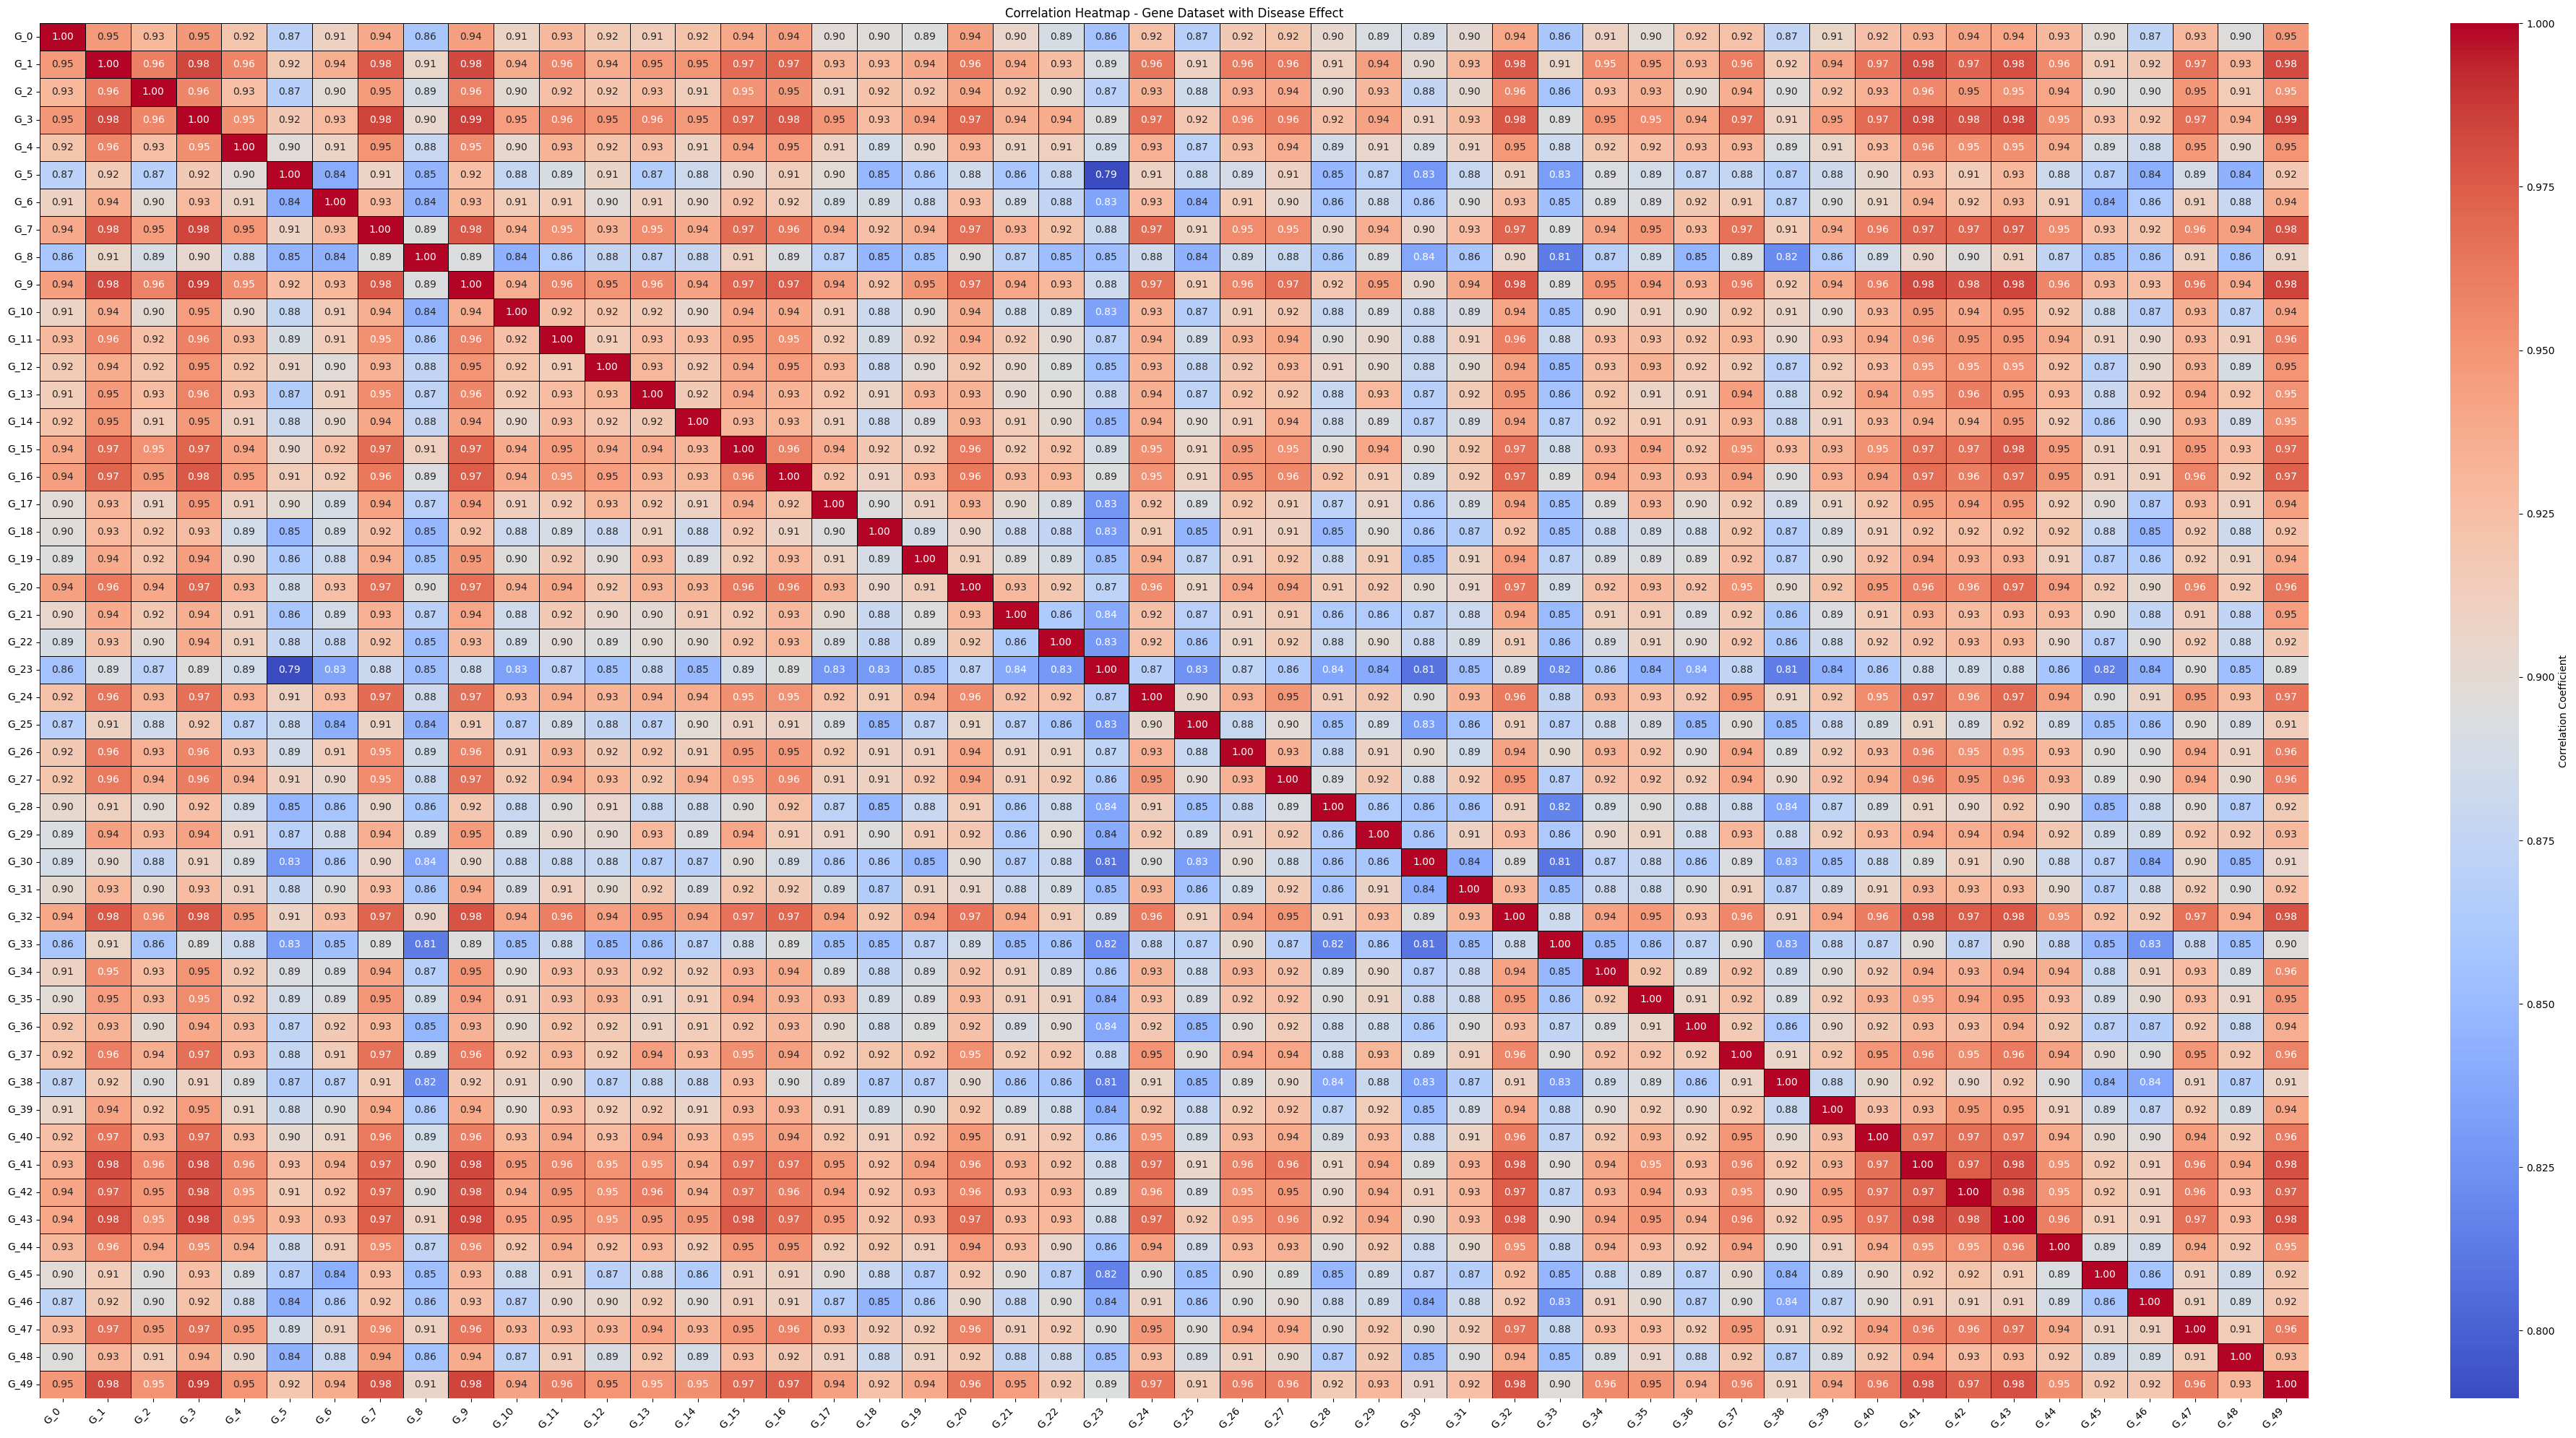

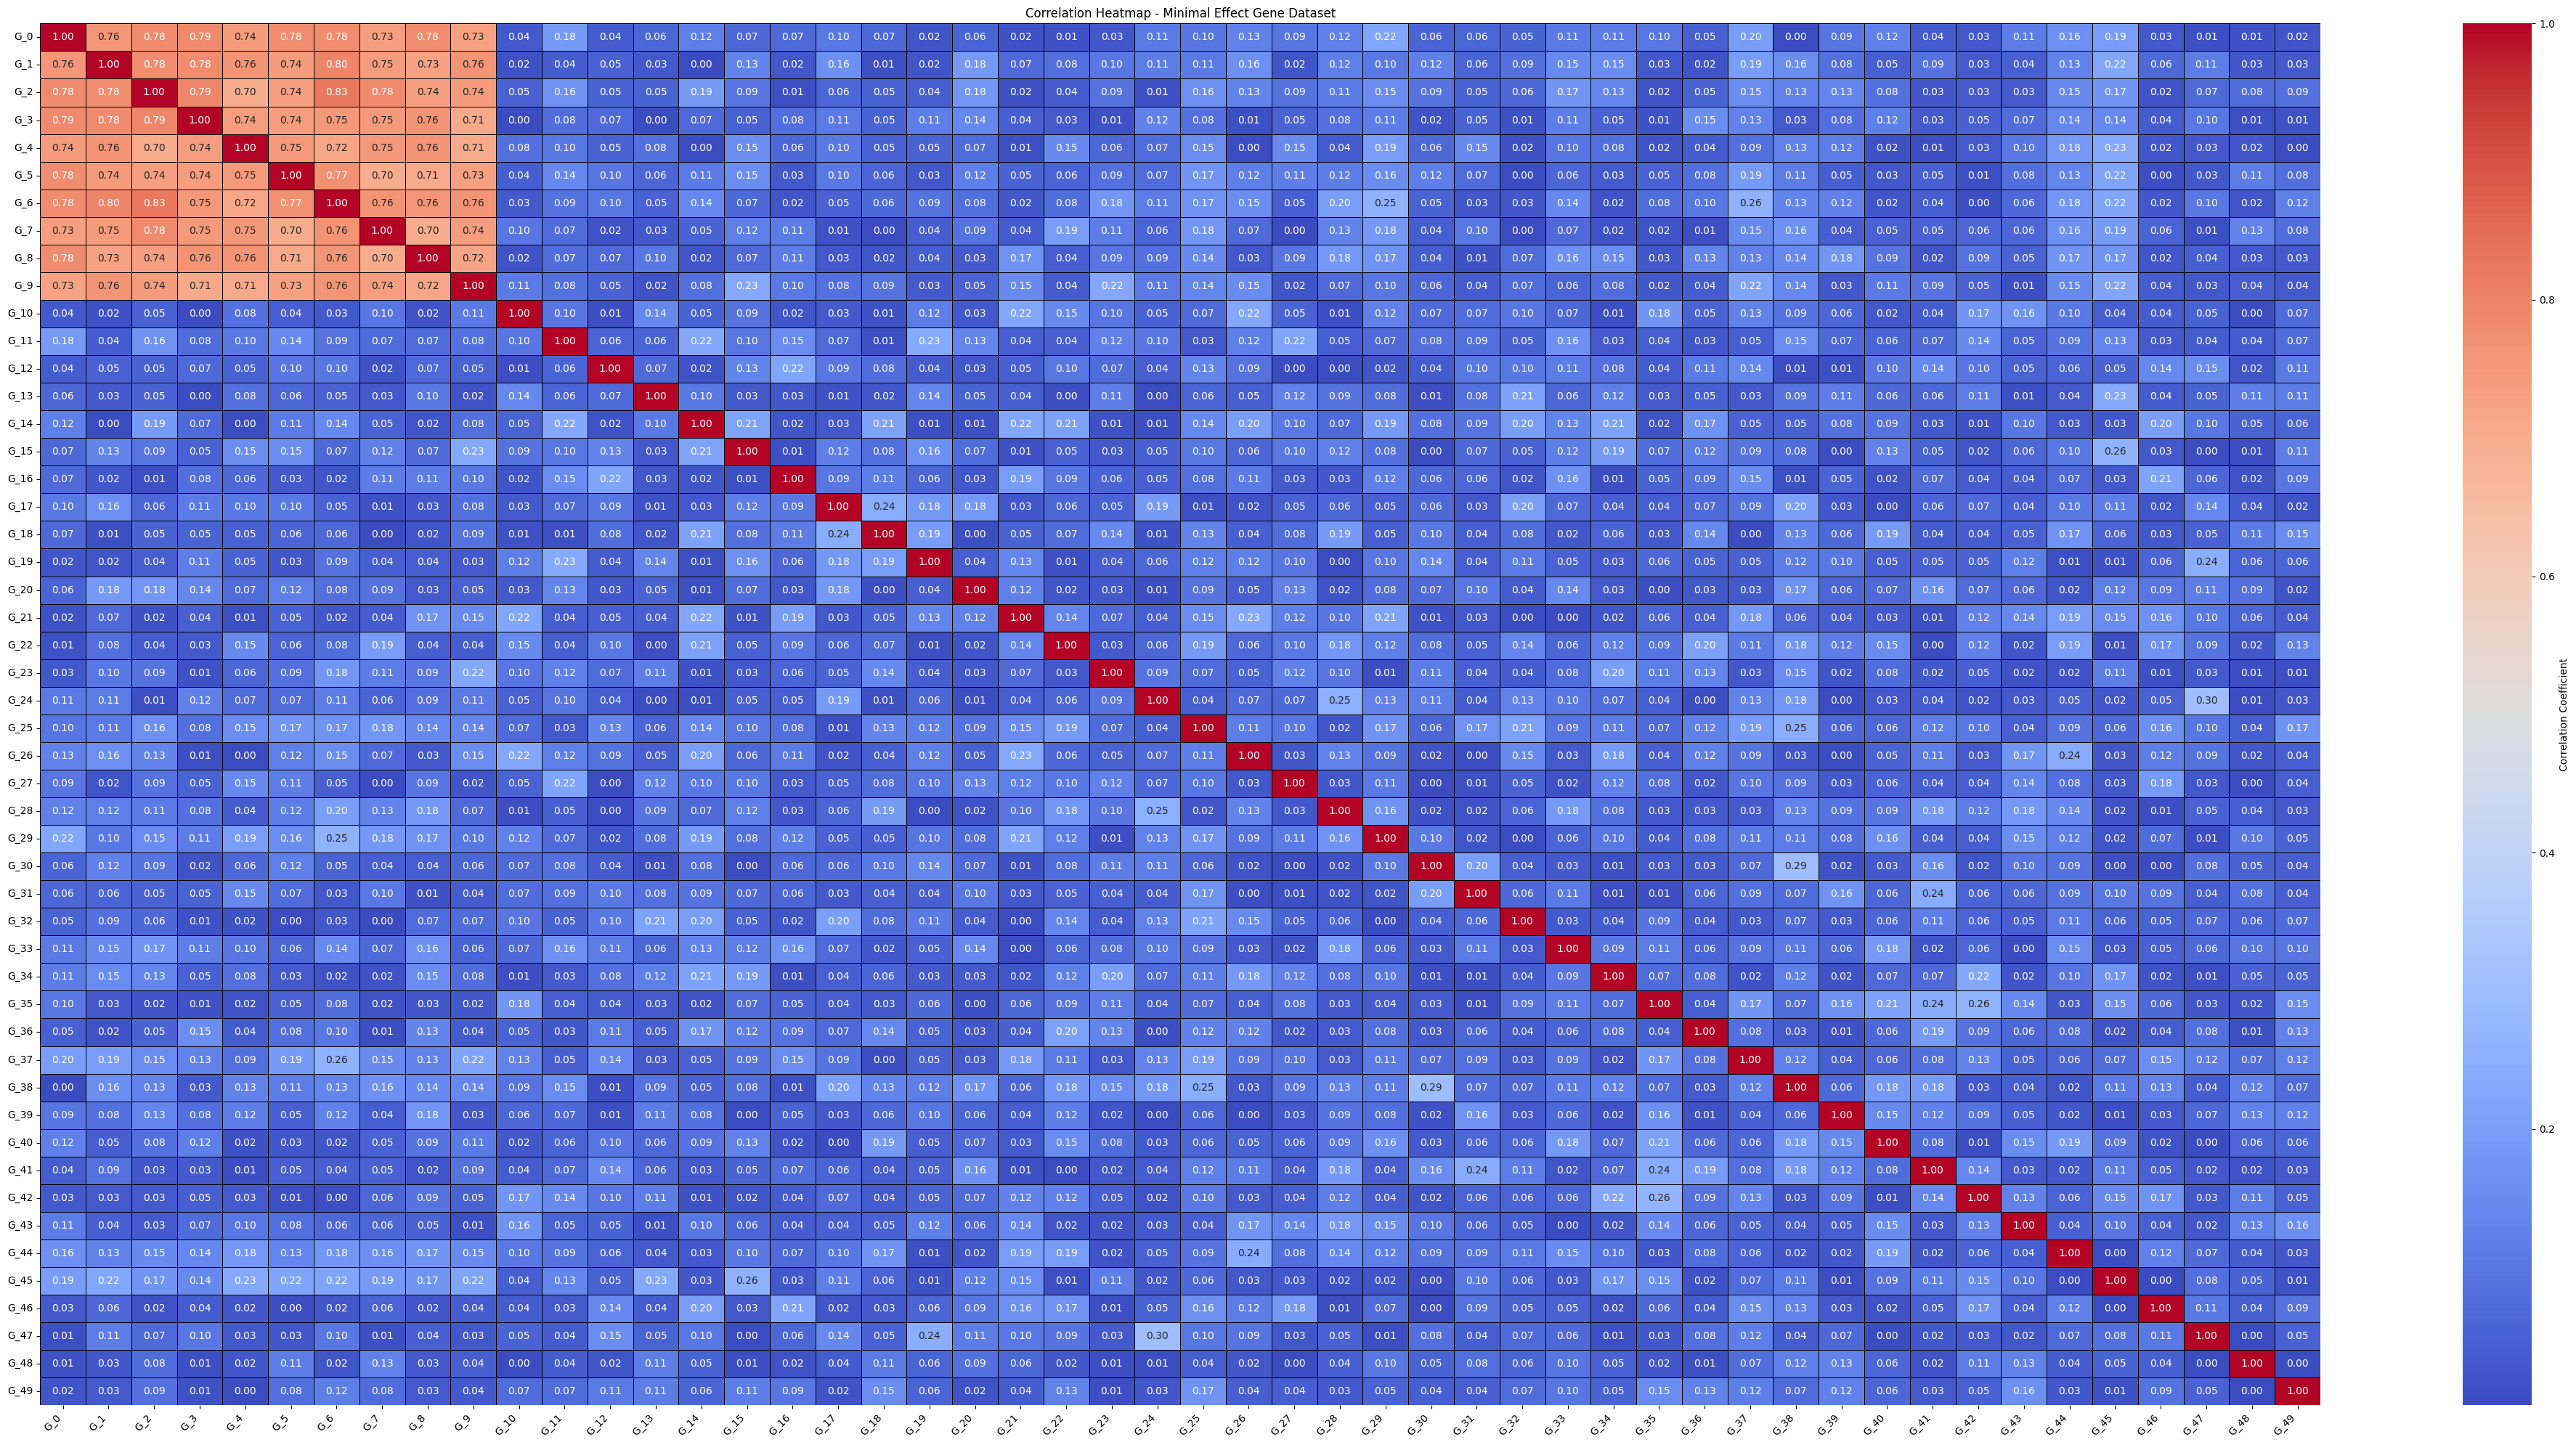

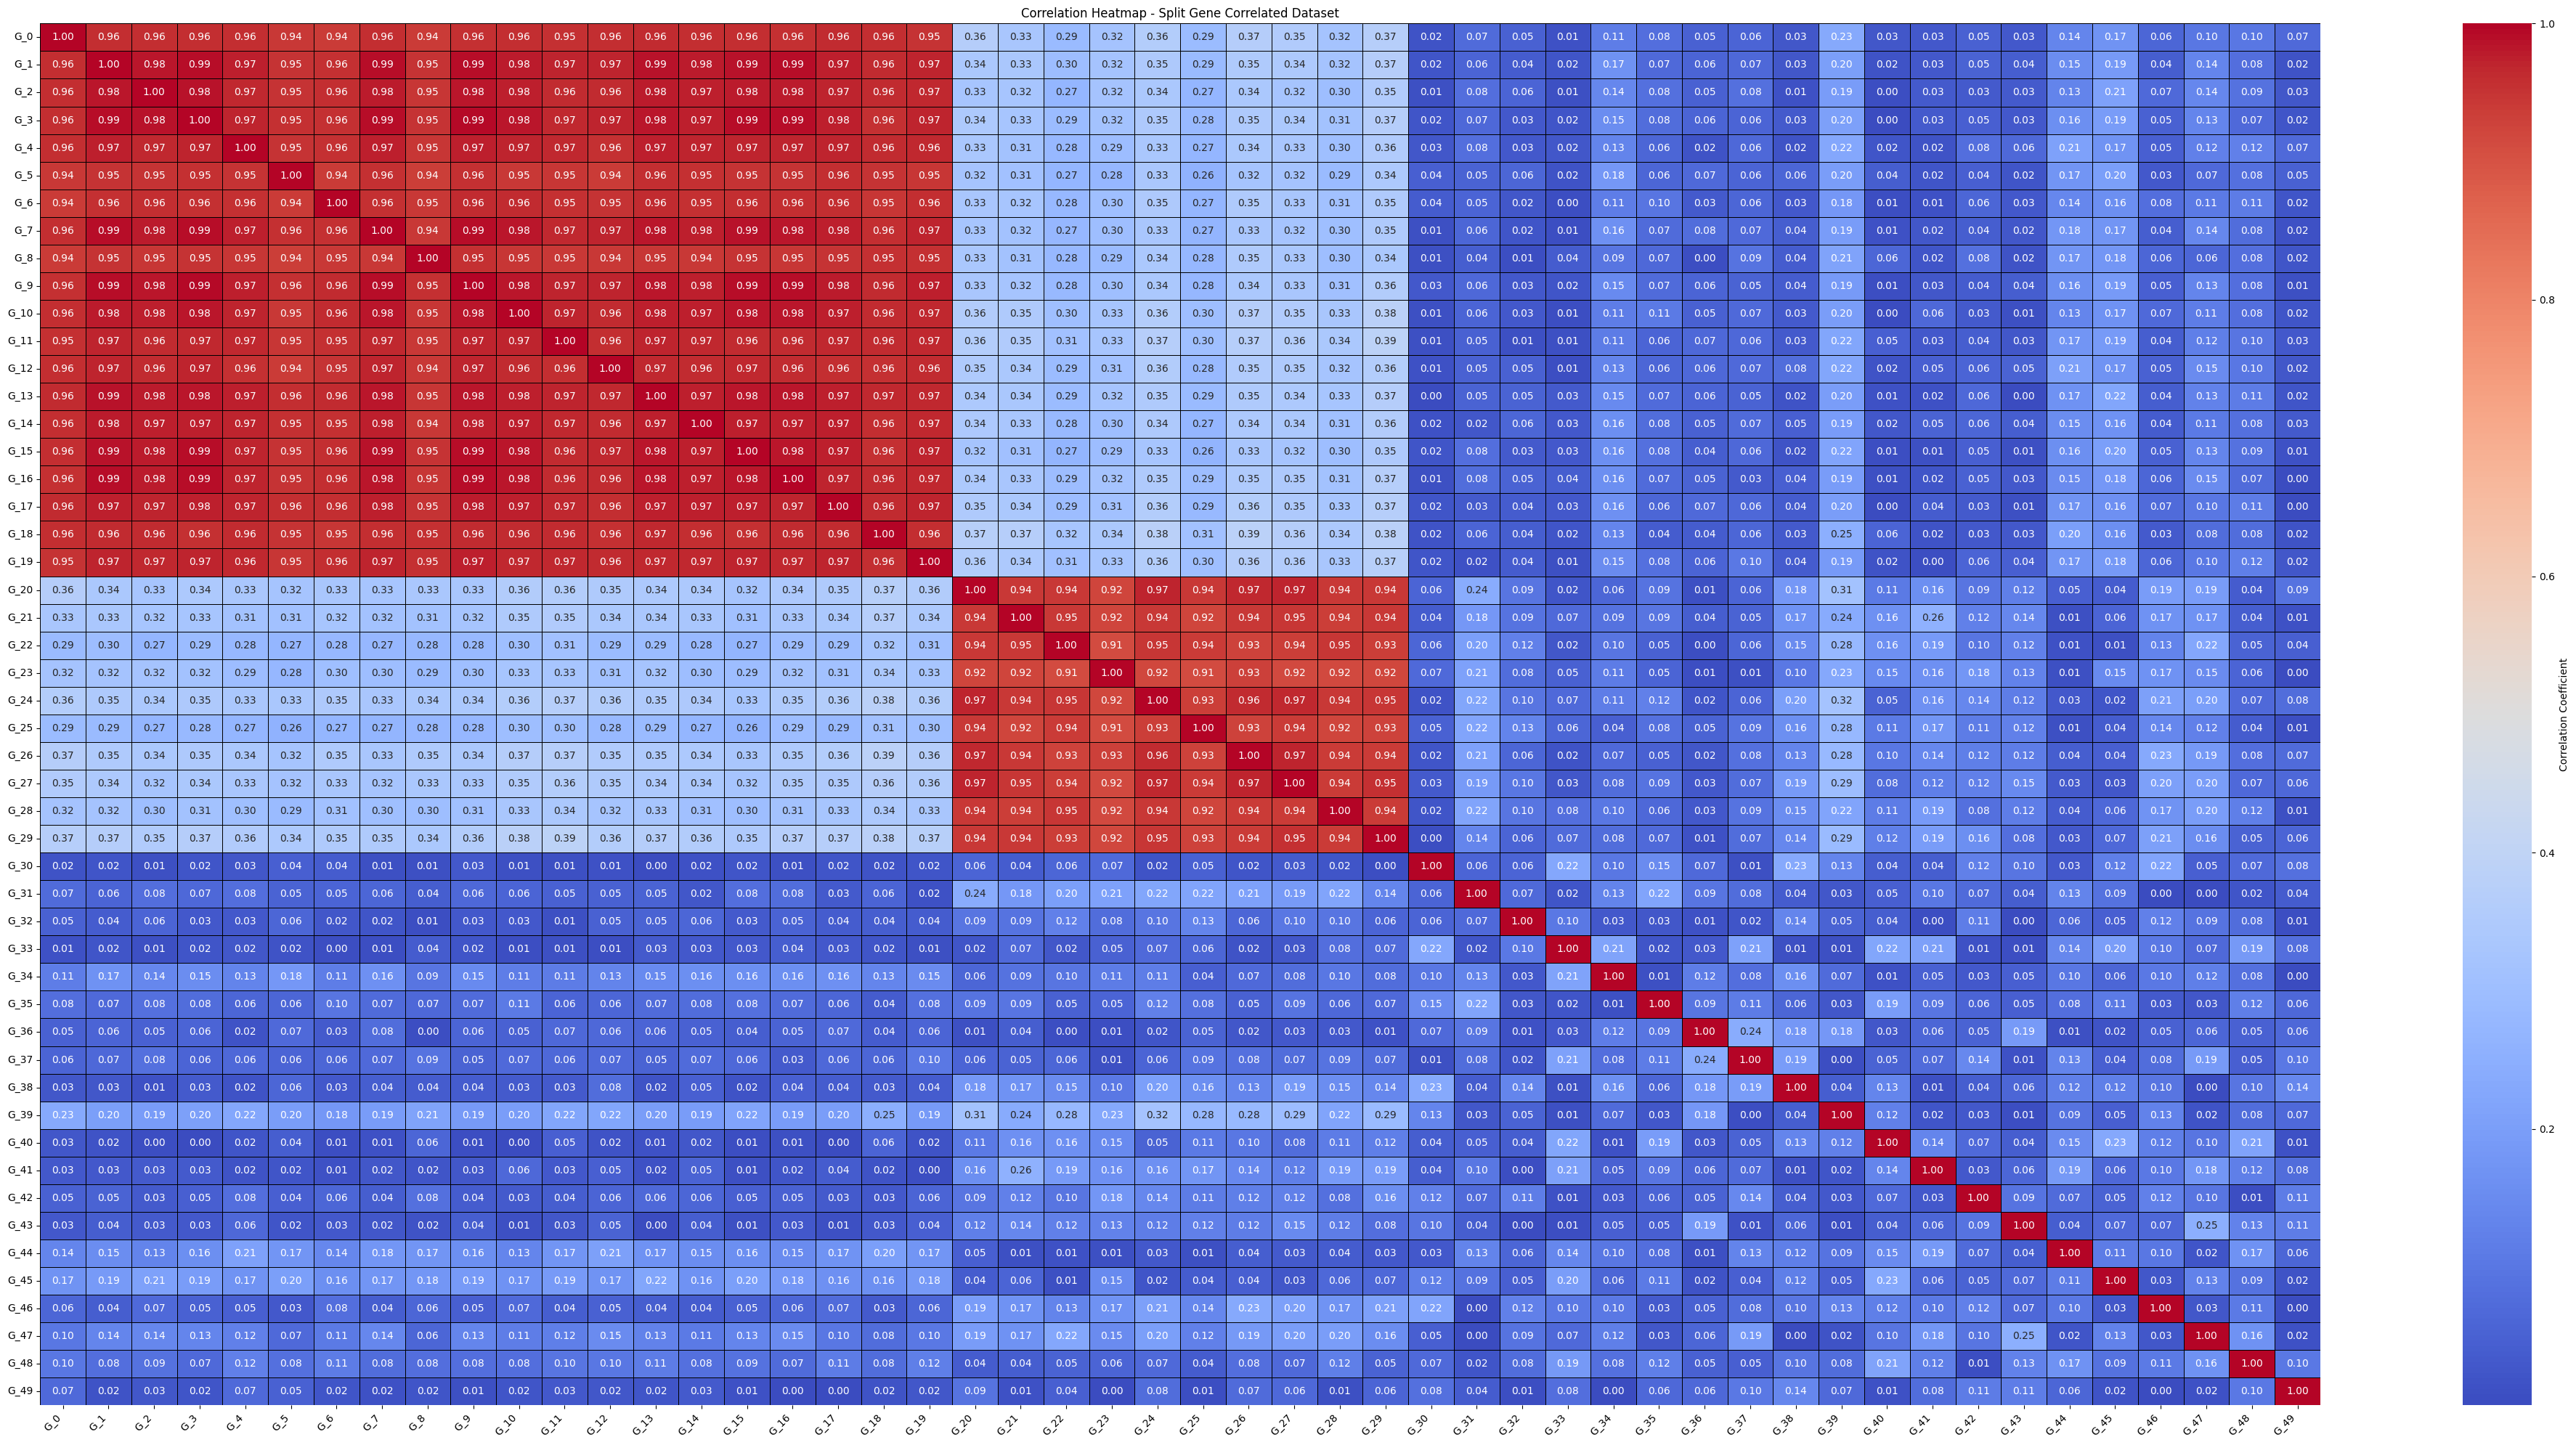

In [46]:
# Train and evaluate the models
train_and_evaluate(df_gene, "Gene Dataset with Disease Effect")
train_and_evaluate(df_minimal, "Minimal Effect Gene Dataset")
train_and_evaluate(df_split, "Split Gene Correlated Dataset")

In [47]:
# Generate the datasets
df_gene = create_gene_dataset_with_disease_effect(
    n_samples=100, # Number of patients
    n_genes=15000,
    num_disease_genes=15000, # Half of the genes correlated with disease
    gene_type="Microarray", # Or "RNA-Seq"
    disease_effect_type="additive_shift", # "additive_shift" for Microarray, "fold_change" for RNA-Seq
    disease_effect_value=[8, 10], # Use a range for a uniform stochastic effect
)

df_minimal = create_minimal_effect_gene_dataset(
    n_samples=100,
    n_genes=15000,
    num_disease_genes=3000,
    num_correlated_genes=3000,
    correlation_value=0.8,
    gene_type="Microarray",
    disease_effect_type="additive_shift",
    disease_effect_value=[0.05, 0.15], # Use a range for a minimal, uniform stochastic effect
)

df_split = create_split_gene_correlated_dataset(
    n_samples=100,
    n_genes=15000,
    num_disease_genes_1=3000,
    num_disease_genes_2=2000,
    corr_group_1=0.6,
    corr_group_2=0.7,
    gene_type="Microarray",
    disease_effect_type="additive_shift",
    disease_effect_type_2="additive_shift",
    disease_effect_value=[20, 24],
    disease_effect_value_2=[10, 15],
    num_patients_subtype_1 = 25)


Starting gene dataset generation with 15000 genes, 15000 disease-correlated.


Generation complete.
Starting gene dataset generation with 15000 genes...
Introducing correlation for a group of 3000 genes.
Generation complete.
Starting gene dataset generation with 15000 genes...
Defining disease subtypes: 25 patients for module 1, remainder for module 2.
Generating gene data with disease subtypes...
Generation complete.


In [48]:
# --- Configuración General ---
N_CLUSTERS = 100              # Número de clústeres de genes
N_COMPONENTS_PCA = 2          # Para el gráfico 2D de PCA/UMAP
N_TOP_CLUSTERS_TO_SHOW = 15   # Para los gráficos de resumen


def train_and_evaluate_cluster(df, dataset_filename):
    """
    Flujo de trabajo "notebook" mejorado (sin guardado de archivos):
    - Muestra todos los gráficos en ventanas emergentes (plt.show()).
    - Imprime resúmenes en la consola (print).
    - Añade UMAP estático.
    - Añade un Clustermap "Top-K" anotado.
    """
    print("--- Modo de visualización 'Notebook' activo (sin guardado) ---")
    print("Resultados se mostrarán en consola y ventanas emergentes.")

    print(f"\n{'='*60}")
    print(f"Processing dataset: {dataset_filename}")
    print(f"{'='*60}")
    
    try:
        df_clean = df.drop(columns=['Unnamed: 0'], errors='ignore')
        X = df_clean.iloc[:, :-1]
        y = df_clean.iloc[:, -1]
        
        gene_names = X.columns.tolist()

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=42, stratify=y
        )

        # --- 1. Escalar Datos ---
        print("\n[1] Scaling data (StandardScaler)...")
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Preparar datos completos para visualización
        X_scaled_full = np.vstack((X_train_scaled, X_test_scaled))
        y_full = pd.concat([y_train, y_test])

        # --- 2a. Visualización PCA (de Muestras) con Seaborn ---
        print(f"\n[2a] Generating PCA plot ({N_COMPONENTS_PCA} components)...")
        n_components_actual = min(N_COMPONENTS_PCA, X_train_scaled.shape[0], X_train_scaled.shape[1])
        if n_components_actual < N_COMPONENTS_PCA:
                print(f"Warning: Reducing PCA components to {n_components_actual} due to data shape.")
        
        pca = PCA(n_components=n_components_actual)
        X_pca = pca.fit_transform(X_scaled_full)
        
        pca_df = pd.DataFrame(
            data=X_pca, 
            columns=[f'PC{i+1}' for i in range(n_components_actual)]
        )
        pca_df['Group'] = y_full.astype(str).values 

        plt.figure(figsize=(10, 8))
        sns.scatterplot(
            data=pca_df, 
            x='PC1', 
            y='PC2', 
            hue='Group',
            palette='bright', s=50, alpha=0.7
        )
        plt.title(f'PCA of Samples (Colored by Group) - {dataset_filename}', fontsize=16)
        plt.xlabel(f'PC1 (Explains {pca.explained_variance_ratio_[0]:.2%} variance)')
        if n_components_actual >= 2:
                plt.ylabel(f'PC2 (Explains {pca.explained_variance_ratio_[1]:.2%} variance)')
        plt.legend(title='Group')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        
        print("Displaying PCA plot (cierre la ventana para continuar)...")
        plt.show()

        # --- 2b. NUEVO: Visualización UMAP (de Muestras) con Seaborn ---
        print(f"\n[2b] Generating UMAP plot ({N_COMPONENTS_PCA} components)...")
        try:
            # UMAP necesita n_neighbors < n_samples
            n_neighbors = min(15, X_scaled_full.shape[0] - 1)
            if n_neighbors < 2:
                print("Warning: Not enough samples for UMAP. Skipping.")
            else:
                reducer = umap.UMAP(n_components=N_COMPONENTS_PCA, n_neighbors=n_neighbors, random_state=42)
                X_umap = reducer.fit_transform(X_scaled_full)
                
                umap_df = pd.DataFrame(data=X_umap, columns=['UMAP1', 'UMAP2'])
                umap_df['Group'] = y_full.astype(str).values

                plt.figure(figsize=(10, 8))
                sns.scatterplot(
                    data=umap_df, 
                    x='UMAP1', 
                    y='UMAP2', 
                    hue='Group',
                    palette='bright', s=50, alpha=0.7
                )
                plt.title(f'UMAP of Samples (Colored by Group) - {dataset_filename}', fontsize=16)
                plt.xlabel('UMAP 1')
                plt.ylabel('UMAP 2')
                plt.legend(title='Group')
                plt.grid(True, linestyle='--', alpha=0.5)
                plt.tight_layout()
                
                print("Displaying UMAP plot (cierre la ventana para continuar)...")
                plt.show()
        except Exception as e:
            print(f"Error during UMAP generation: {e}. Skipping UMAP plot.")


        # --- 3. Agrupación de Features (Feature Agglomeration) ---
        n_features = X_train_scaled.shape[1]
        n_clusters_actual = min(N_CLUSTERS, n_features)
        if n_clusters_actual < N_CLUSTERS:
            print(f"Warning: Reducing cluster count to {n_clusters_actual} (equal to feature count).")
            
        print(f"\n[3] Clustering {len(gene_names)} features into {n_clusters_actual} groups...")
        agglo = FeatureAgglomeration(n_clusters=n_clusters_actual)
        agglo.fit(X_train_scaled)
        
        X_train_clustered = agglo.transform(X_train_scaled)
        X_test_clustered = agglo.transform(X_test_scaled)
        print(f"Data transformed from {X_train_scaled.shape[1]} to {X_train_clustered.shape[1]} features.")

        # --- 4. MOSTRAR EL MAPA DE GENES A CLÚSTERES (Top 20) ---
        print(f"\n[4] Displaying gene-to-cluster mapping ...")
        cluster_map_df = pd.DataFrame({
            'Gene': gene_names,
            'ClusterID': agglo.labels_
        }).sort_values(by='ClusterID')
        
        print(cluster_map_df.to_string())

        # --- 5. Entrenar Modelo sobre Clústeres ---
        print(f"\n[5] Training model on {n_clusters_actual} clustered features...")
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
        model.fit(X_train_clustered, y_train)
        
        predictions = model.predict(X_test_clustered)
        accuracy = accuracy_score(y_test, predictions)
        print(f"Model Accuracy on {n_clusters_actual} clusters: {accuracy:.4f}")

        # --- 6. Importancia de Clústeres (Permutation Importance) ---
        print(f"\n[6] Calculating Permutation Importance for {n_clusters_actual} clusters...")
        cluster_names = [f'Cluster_{i}' for i in range(n_clusters_actual)]
        
        perm_importance = permutation_importance(
            model, X_test_clustered, y_test, n_repeats=10, random_state=42, n_jobs=-1
        )
        
        perm_imp_df = pd.DataFrame({
            'Cluster': cluster_names,
            'ImportanceMean': perm_importance.importances_mean,
            'ImportanceStd': perm_importance.importances_std
        }).sort_values(by='ImportanceMean', ascending=False)
        
        print("Top 10 Most Important Gene Clusters (Consola):")
        print(perm_imp_df.head(10).to_string())
        
        
        # --- 6a. Gráfico de Barras de Permutation Importance ---
        print(f"\n[6a] Generating Permutation Importance plot (Top {N_TOP_CLUSTERS_TO_SHOW})...")
        n_top_actual = min(N_TOP_CLUSTERS_TO_SHOW, n_clusters_actual)
        top_clusters_df = perm_imp_df.head(n_top_actual).sort_values(by='ImportanceMean', ascending=True)

        plt.figure(figsize=(12, 8))
        plt.barh(
            top_clusters_df['Cluster'],
            top_clusters_df['ImportanceMean'],
            xerr=top_clusters_df['ImportanceStd'],
            align='center', alpha=0.8, capsize=5
        )
        plt.title(f'Top {n_top_actual} Most Important Gene Clusters\n{dataset_filename}', fontsize=16)
        plt.xlabel('Importance (Mean Decrease in Accuracy)', fontsize=12)
        plt.ylabel('Gene Cluster', fontsize=12)
        plt.margins(y=0.01)
        plt.grid(True, linestyle='--', alpha=0.5, axis='x')
        plt.tight_layout()
        
        print("Displaying Permutation Importance plot (cierre la ventana para continuar)...")
        plt.show()

        # --- 7a. Clustermap COMPLETO (Sin etiquetas) ---
        print(f"\n[7a] Generating FULL clustermap ({n_clusters_actual} clusters)...")
        print(f"Note: Ocultando etiquetas para mejor visibilidad de la estructura.")
        
        X_train_clustered_df = pd.DataFrame(X_train_clustered, columns=cluster_names)
        corr_matrix_clusters = X_train_clustered_df.corr()
        
        fig_size_dim = min(20, max(12, n_clusters_actual * 0.15)) 
        
        g = sns.clustermap(
            corr_matrix_clusters,
            figsize=(fig_size_dim, fig_size_dim),
            cmap='vlag',
            annot=False,
            linewidths=.2,
            center=0,
            xticklabels=False,
            yticklabels=False
        )
        g.fig.suptitle(f'Clustermap de Correlación (TODOS {n_clusters_actual} Clusters)\n{dataset_filename}', y=1.02, fontsize=16)

        print("Displaying FULL clustermap (cierre la ventana para continuar)...")
        plt.show()

        # --- 7b. NUEVO: Clustermap TOP-K (Con etiquetas y anotaciones) ---
        print(f"\n[7b] Generating TOP {n_top_actual} clustermap (con etiquetas)...")
        
        # Filtrar la matriz de correlación para incluir solo los clústeres Top-K
        top_cluster_names = perm_imp_df.head(n_top_actual)['Cluster'].tolist()
        corr_matrix_top_k = corr_matrix_clusters.loc[top_cluster_names, top_cluster_names]

        # El tamaño puede ser más pequeño y legible
        fig_size_top_k = max(10, n_top_actual * 0.7) 

        g_top = sns.clustermap(
            corr_matrix_top_k,
            figsize=(fig_size_top_k, fig_size_top_k),
            cmap='vlag',
            annot=True,     # <-- Mostrar valores
            fmt=".2f",      # <-- Formato de los valores
            linewidths=.5,
            center=0,
            xticklabels=True, # <-- Mostrar etiquetas
            yticklabels=True
        )
        
        g_top.fig.suptitle(f'Clustermap de Correlación (Top {n_top_actual} Clusters)\n{dataset_filename}', y=1.02, fontsize=16)
        plt.setp(g_top.ax_heatmap.get_xticklabels(), rotation=90)
        plt.setp(g_top.ax_heatmap.get_yticklabels(), rotation=0)

        print("Displaying TOP-K clustermap (cierre la ventana para continuar)...")
        plt.show()

    except Exception as e:
        print(f"An error occurred while processing {dataset_filename}: {e}")
        traceback.print_exc()

--- Modo de visualización 'Notebook' activo (sin guardado) ---
Resultados se mostrarán en consola y ventanas emergentes.

Processing dataset: Gene Dataset with Disease Effect - Large

[1] Scaling data (StandardScaler)...

[2a] Generating PCA plot (2 components)...
Displaying PCA plot (cierre la ventana para continuar)...


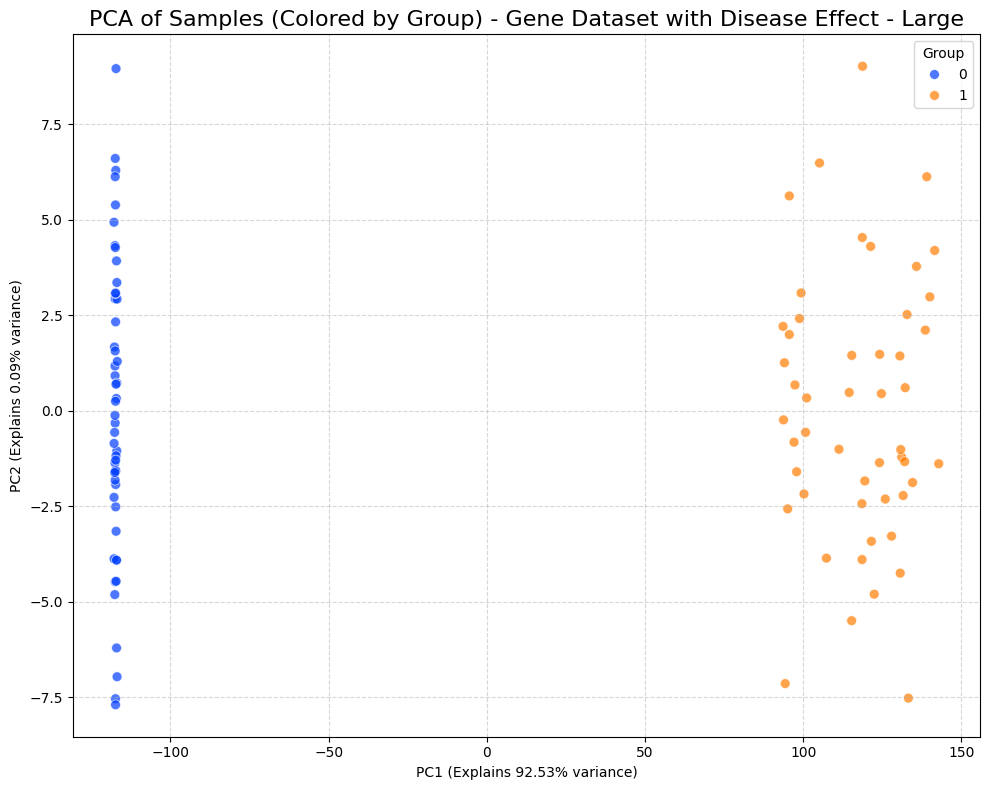


[2b] Generating UMAP plot (2 components)...
Error during UMAP generation: module 'umap' has no attribute 'UMAP'. Skipping UMAP plot.

[3] Clustering 15000 features into 100 groups...
Data transformed from 15000 to 100 features.

[4] Displaying gene-to-cluster mapping ...
          Gene  ClusterID
7826    G_7826          0
11857  G_11857          0
5861    G_5861          0
9131    G_9131          0
5858    G_5858          0
5832    G_5832          0
6830    G_6830          0
13571  G_13571          0
242      G_242          0
10276  G_10276          0
6881    G_6881          0
6606    G_6606          0
3168    G_3168          0
2452    G_2452          0
12138  G_12138          0
5676    G_5676          0
7092    G_7092          0
12177  G_12177          0
5619    G_5619          0
1708    G_1708          0
1960    G_1960          0
14776  G_14776          0
13254  G_13254          0
5739    G_5739          0
2827    G_2827          0
9242    G_9242          0
13844  G_13844          0

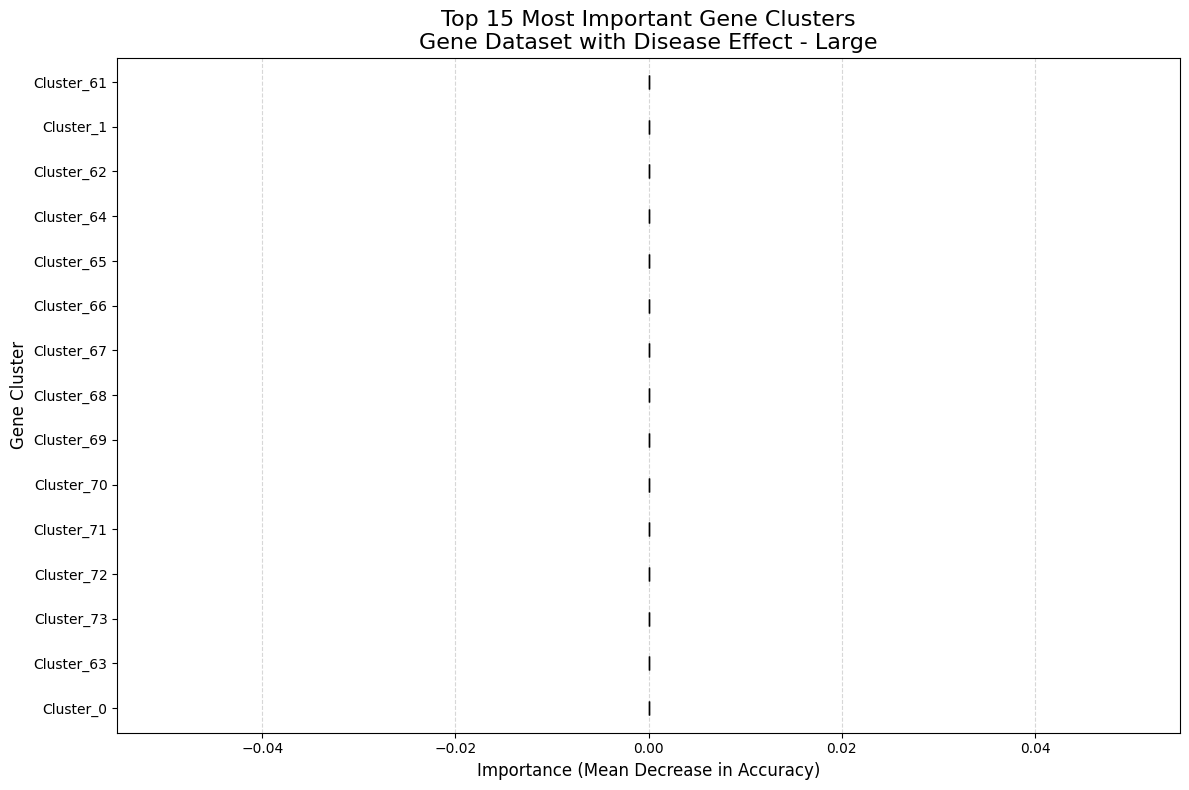


[7a] Generating FULL clustermap (100 clusters)...
Note: Ocultando etiquetas para mejor visibilidad de la estructura.
Displaying FULL clustermap (cierre la ventana para continuar)...


/home/alexbf/calmops-env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/alexbf/calmops-env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


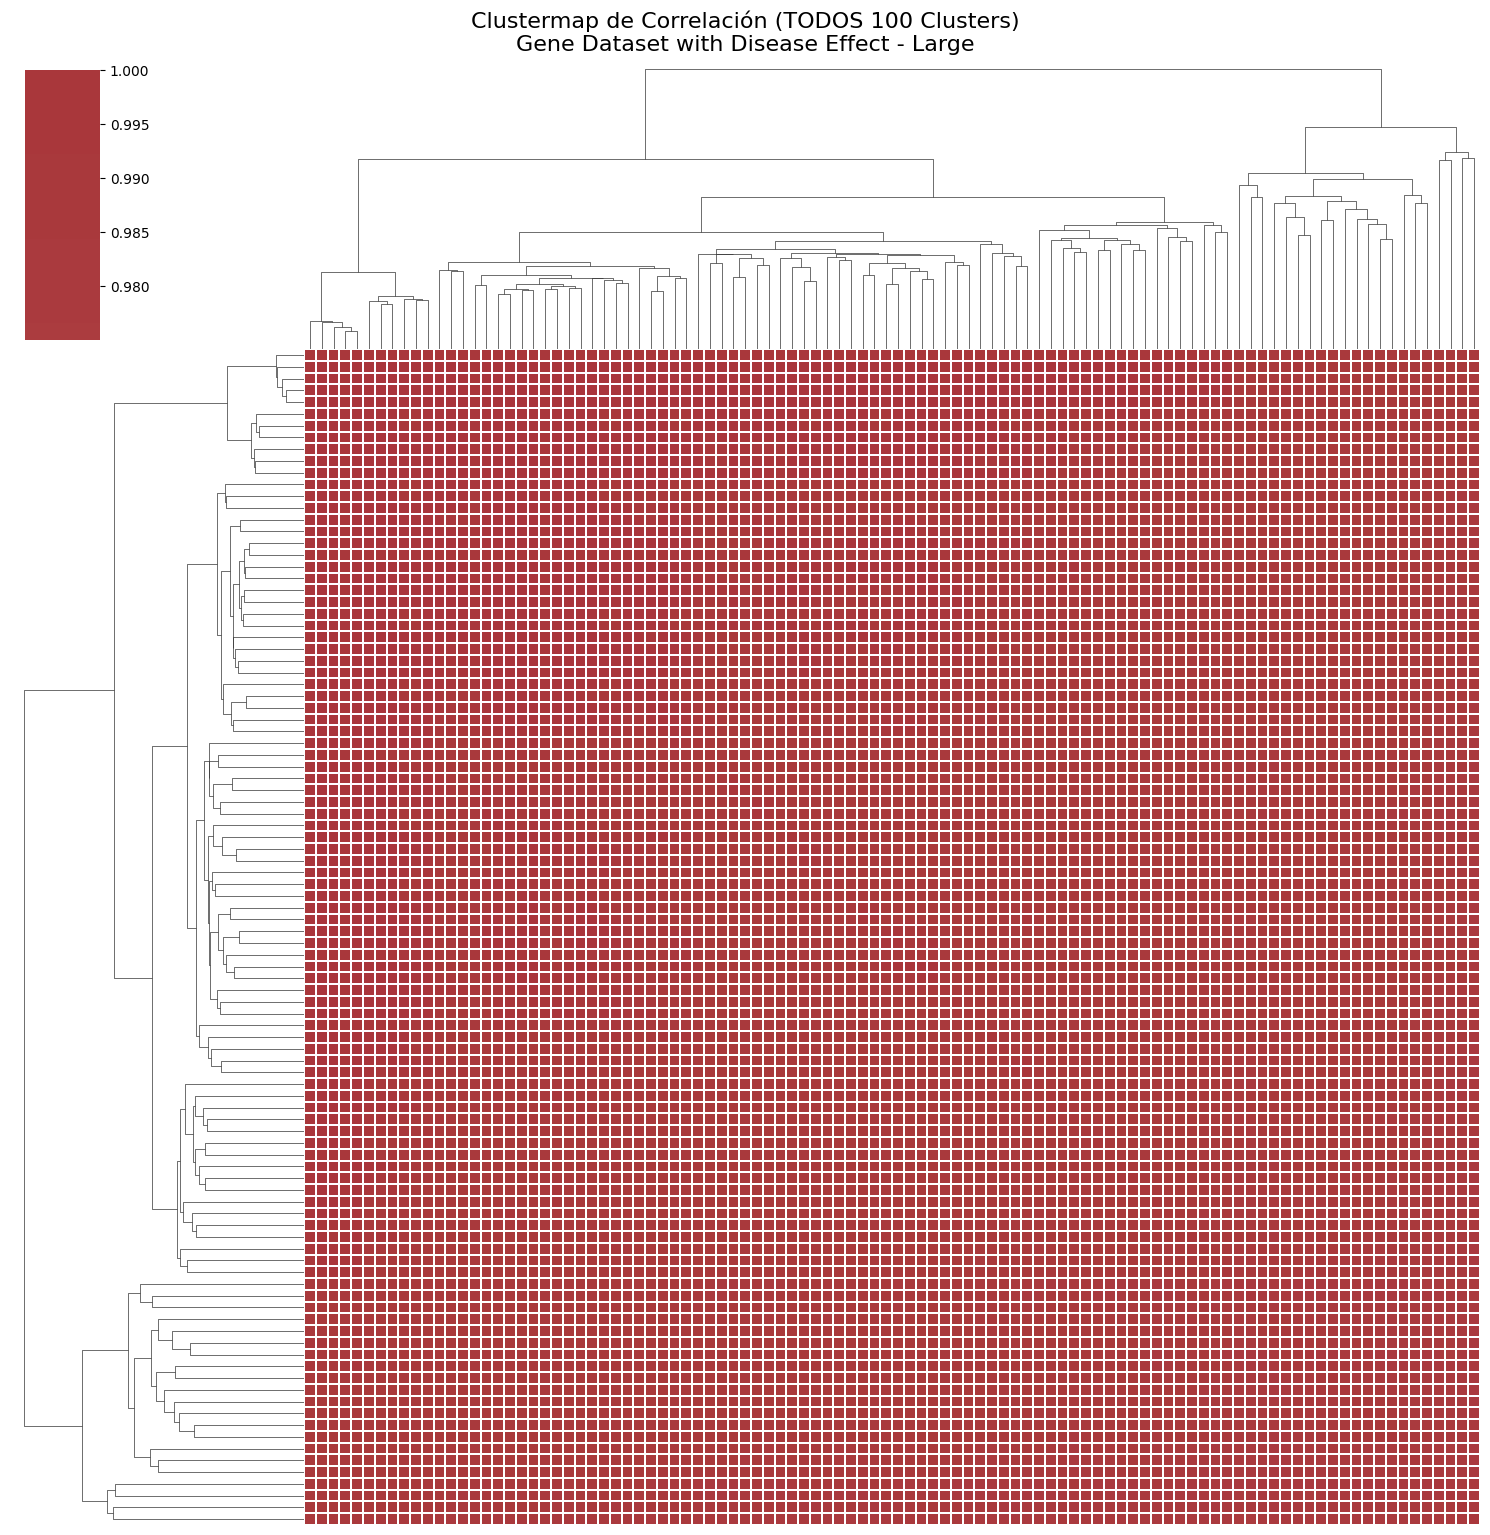


[7b] Generating TOP 15 clustermap (con etiquetas)...
Displaying TOP-K clustermap (cierre la ventana para continuar)...


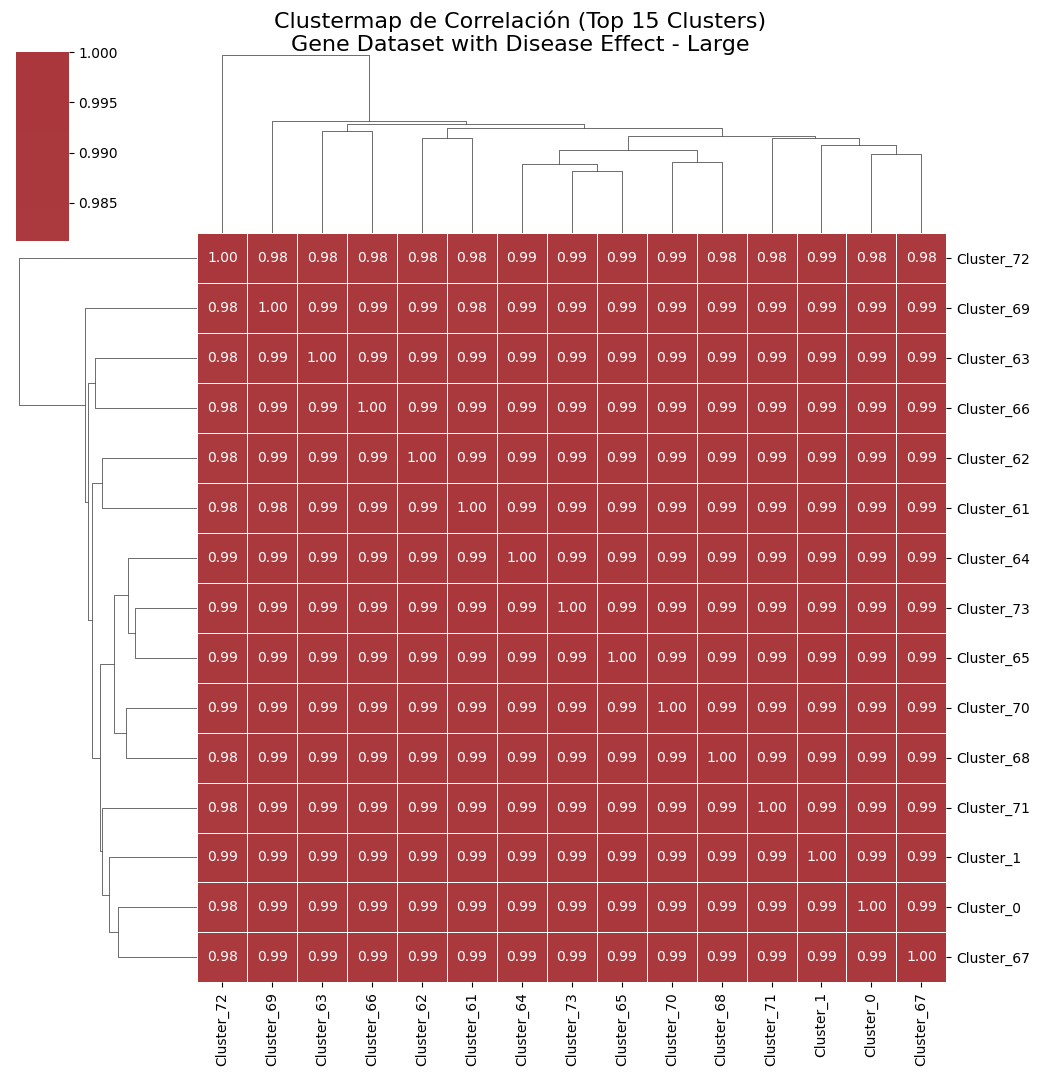

--- Modo de visualización 'Notebook' activo (sin guardado) ---
Resultados se mostrarán en consola y ventanas emergentes.

Processing dataset: Minimal Effect Gene Dataset - Large

[1] Scaling data (StandardScaler)...

[2a] Generating PCA plot (2 components)...
Displaying PCA plot (cierre la ventana para continuar)...


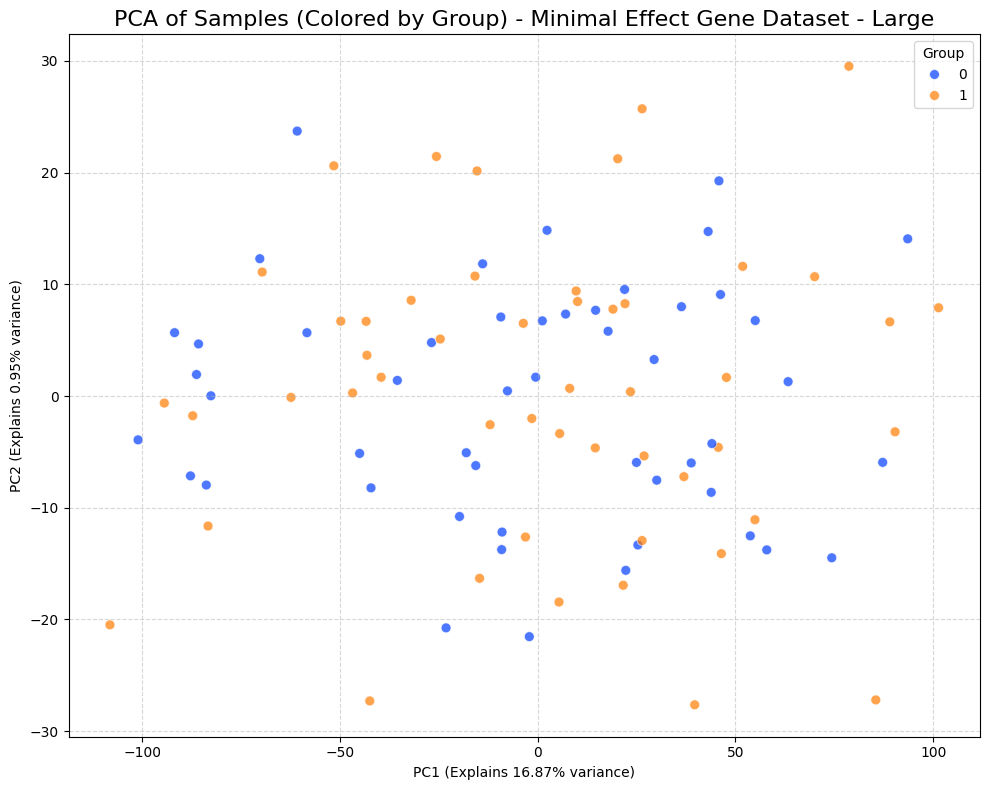


[2b] Generating UMAP plot (2 components)...
Error during UMAP generation: module 'umap' has no attribute 'UMAP'. Skipping UMAP plot.

[3] Clustering 15000 features into 100 groups...
Data transformed from 15000 to 100 features.

[4] Displaying gene-to-cluster mapping ...
          Gene  ClusterID
3037    G_3037          0
14368  G_14368          0
4684    G_4684          0
9462    G_9462          0
3028    G_3028          0
13006  G_13006          0
4732    G_4732          0
4673    G_4673          0
14451  G_14451          0
6922    G_6922          0
8570    G_8570          0
14485  G_14485          0
6940    G_6940          0
4826    G_4826          0
11009  G_11009          0
6914    G_6914          0
11026  G_11026          0
14360  G_14360          0
3077    G_3077          0
6734    G_6734          0
4539    G_4539          0
6737    G_6737          0
6740    G_6740          0
9497    G_9497          0
6753    G_6753          0
9474    G_9474          0
13122  G_13122          0

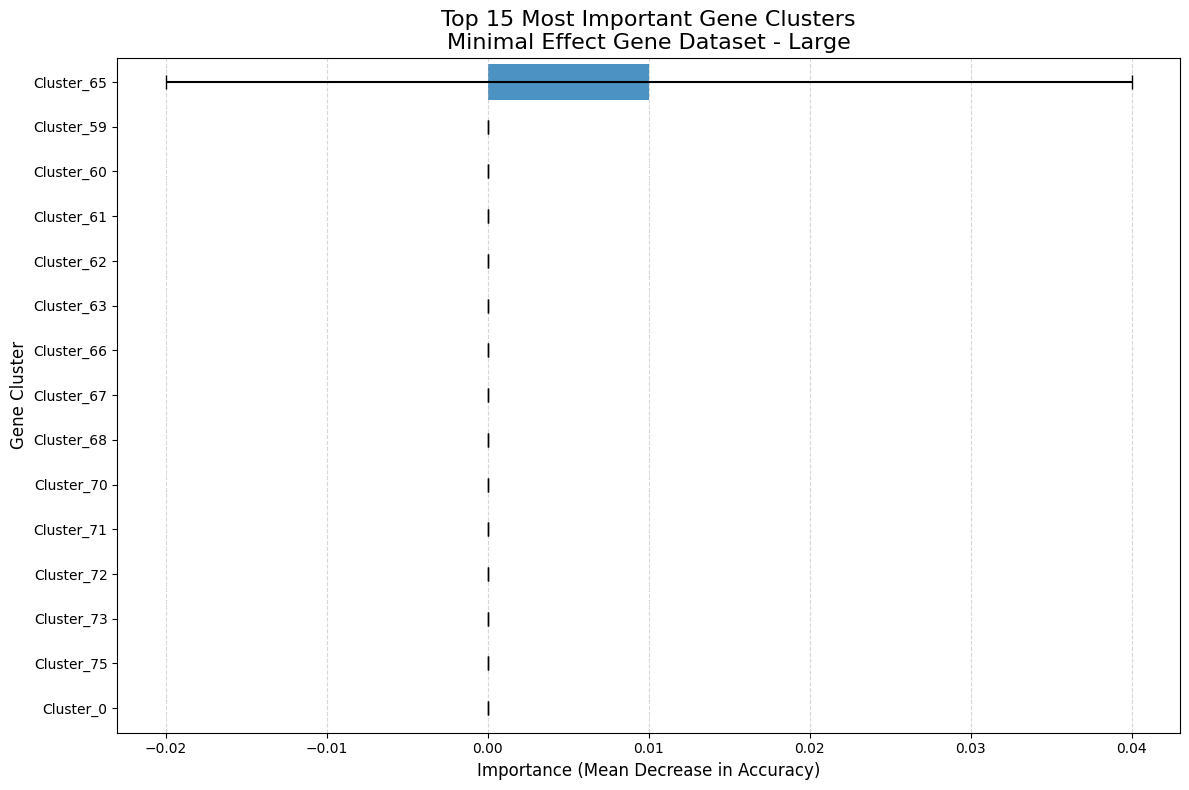


[7a] Generating FULL clustermap (100 clusters)...
Note: Ocultando etiquetas para mejor visibilidad de la estructura.
Displaying FULL clustermap (cierre la ventana para continuar)...


/home/alexbf/calmops-env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/alexbf/calmops-env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


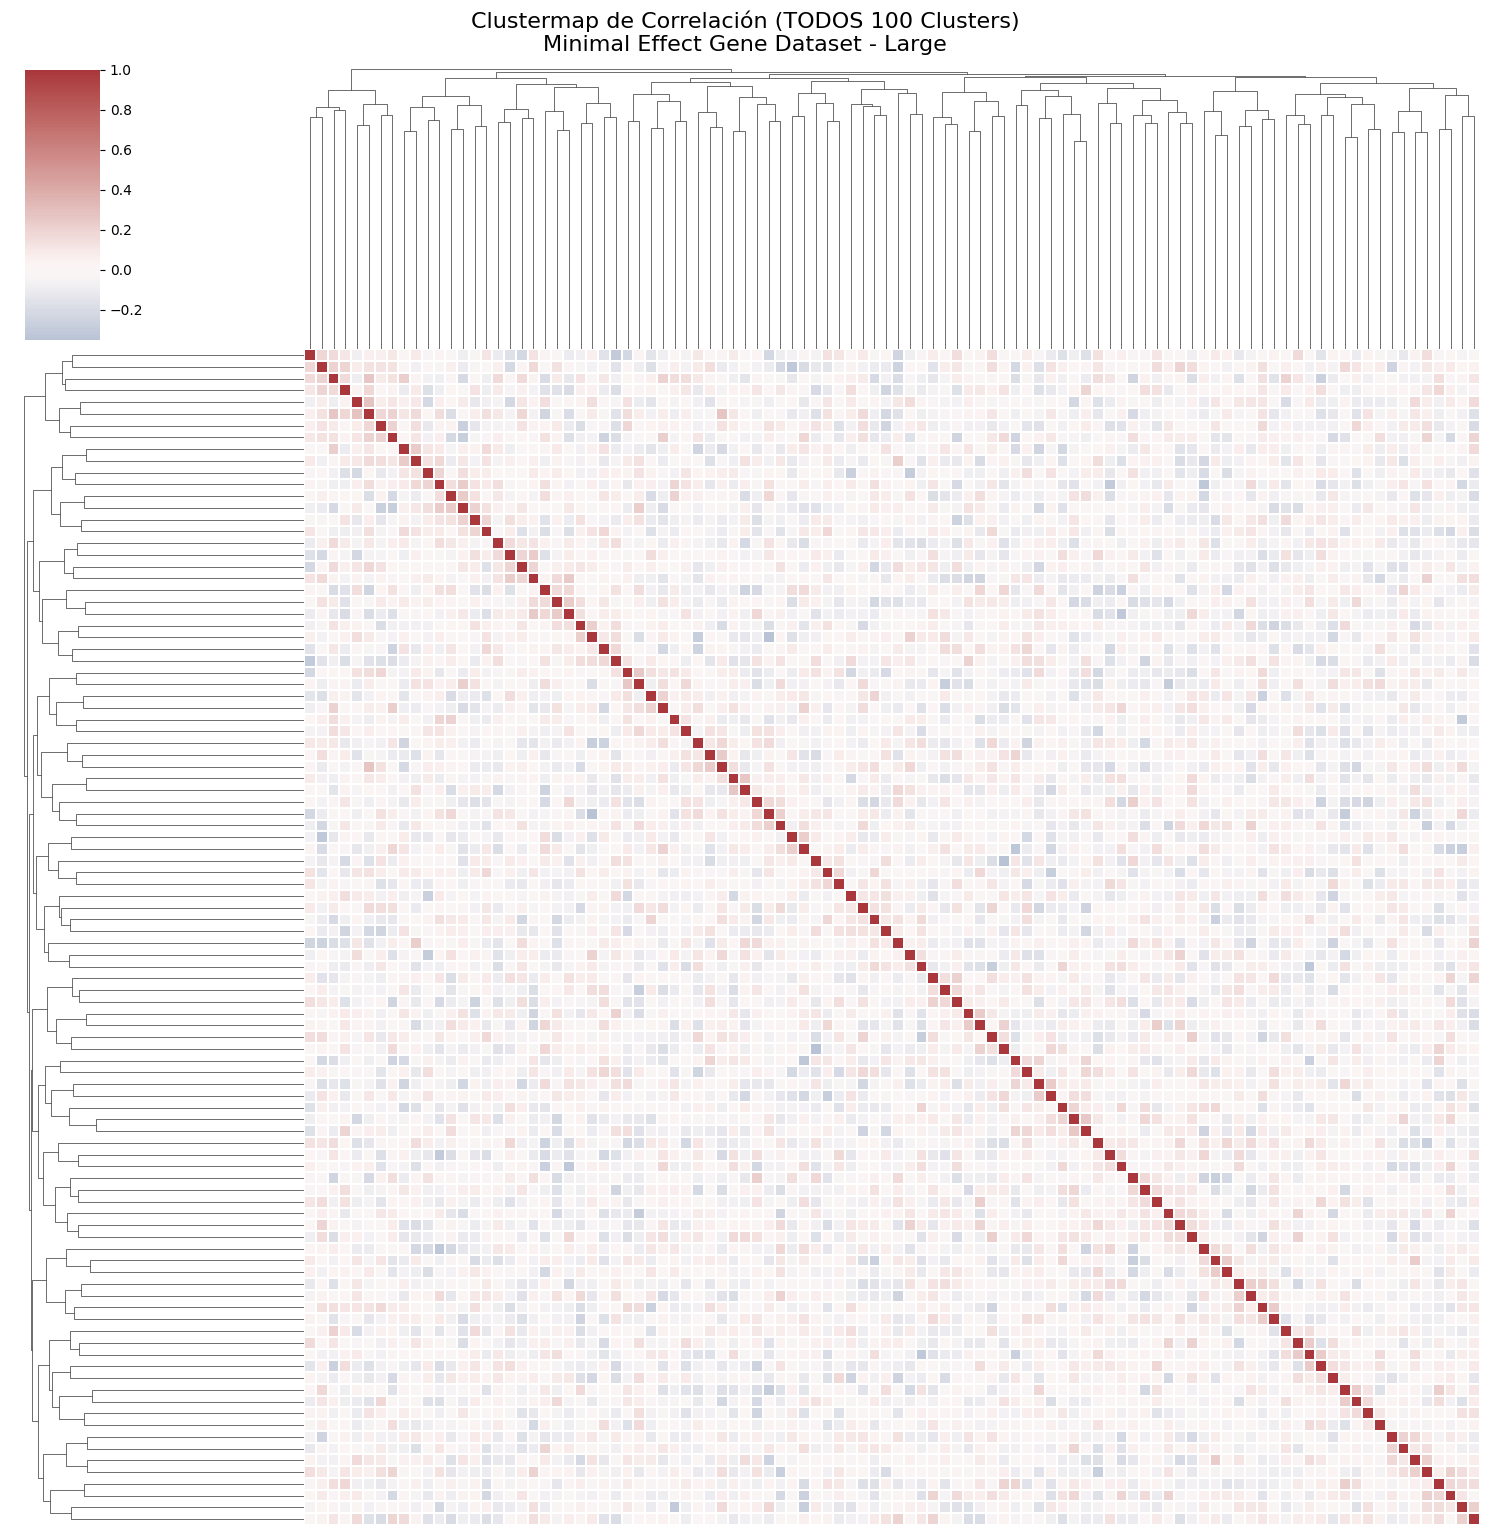


[7b] Generating TOP 15 clustermap (con etiquetas)...
Displaying TOP-K clustermap (cierre la ventana para continuar)...


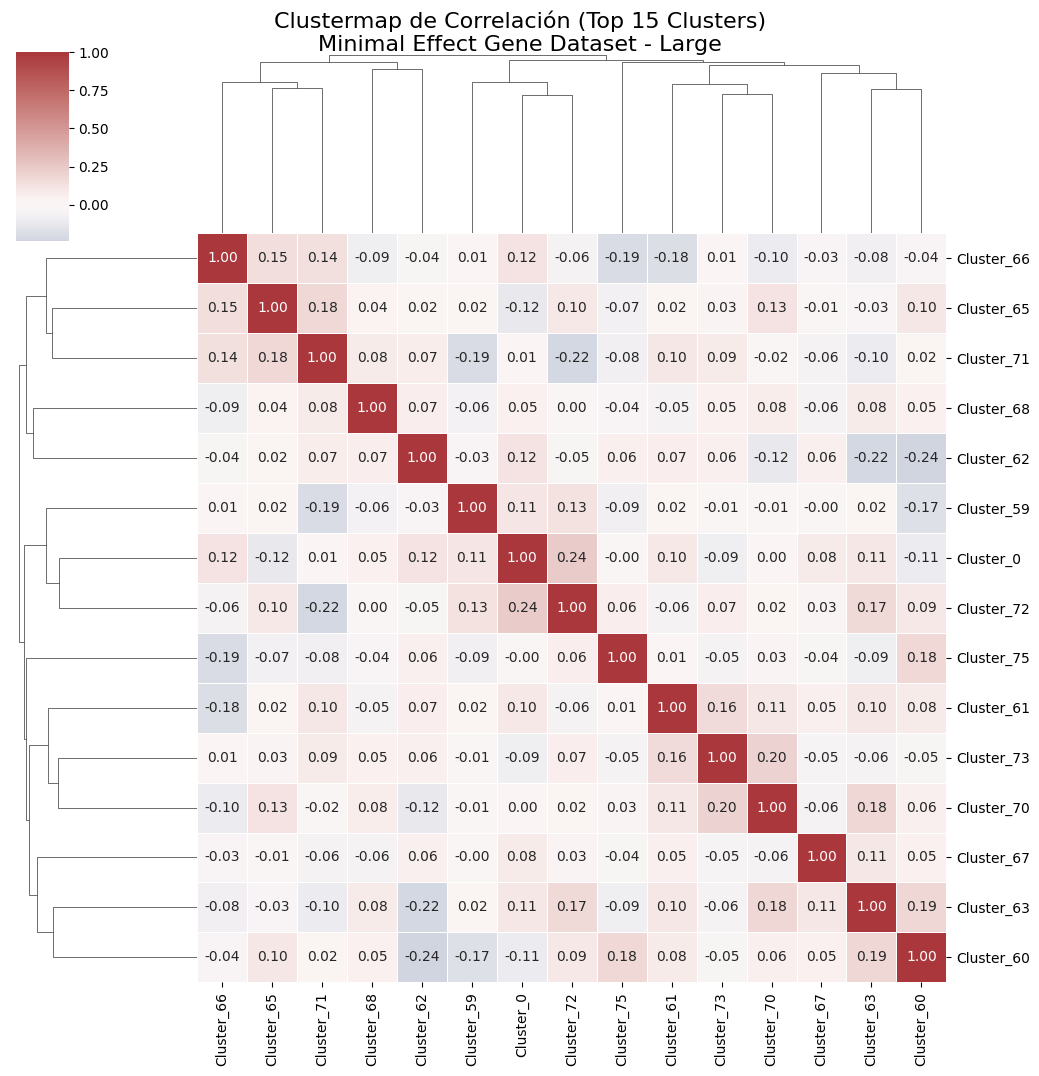

--- Modo de visualización 'Notebook' activo (sin guardado) ---
Resultados se mostrarán en consola y ventanas emergentes.

Processing dataset: Split Gene Correlated Dataset - Large

[1] Scaling data (StandardScaler)...

[2a] Generating PCA plot (2 components)...
Displaying PCA plot (cierre la ventana para continuar)...


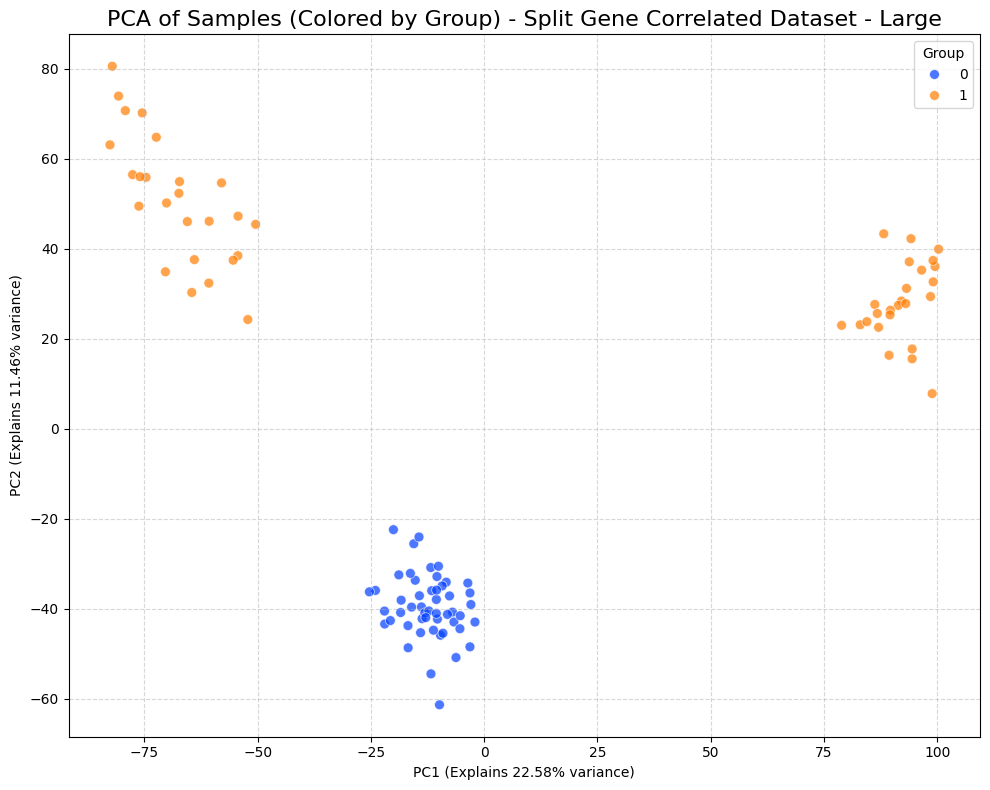


[2b] Generating UMAP plot (2 components)...
Error during UMAP generation: module 'umap' has no attribute 'UMAP'. Skipping UMAP plot.

[3] Clustering 15000 features into 100 groups...
Data transformed from 15000 to 100 features.

[4] Displaying gene-to-cluster mapping ...
          Gene  ClusterID
8018    G_8018          0
11279  G_11279          0
11150  G_11150          0
7966    G_7966          0
6250    G_6250          0
13632  G_13632          0
7967    G_7967          0
6096    G_6096          0
5999    G_5999          0
8322    G_8322          0
9660    G_9660          0
14097  G_14097          0
7007    G_7007          0
11179  G_11179          0
11969  G_11969          0
13136  G_13136          0
6799    G_6799          0
12848  G_12848          0
14686  G_14686          0
12291  G_12291          0
5935    G_5935          0
6098    G_6098          0
13755  G_13755          0
9084    G_9084          0
10975  G_10975          0
6901    G_6901          0
12251  G_12251          0

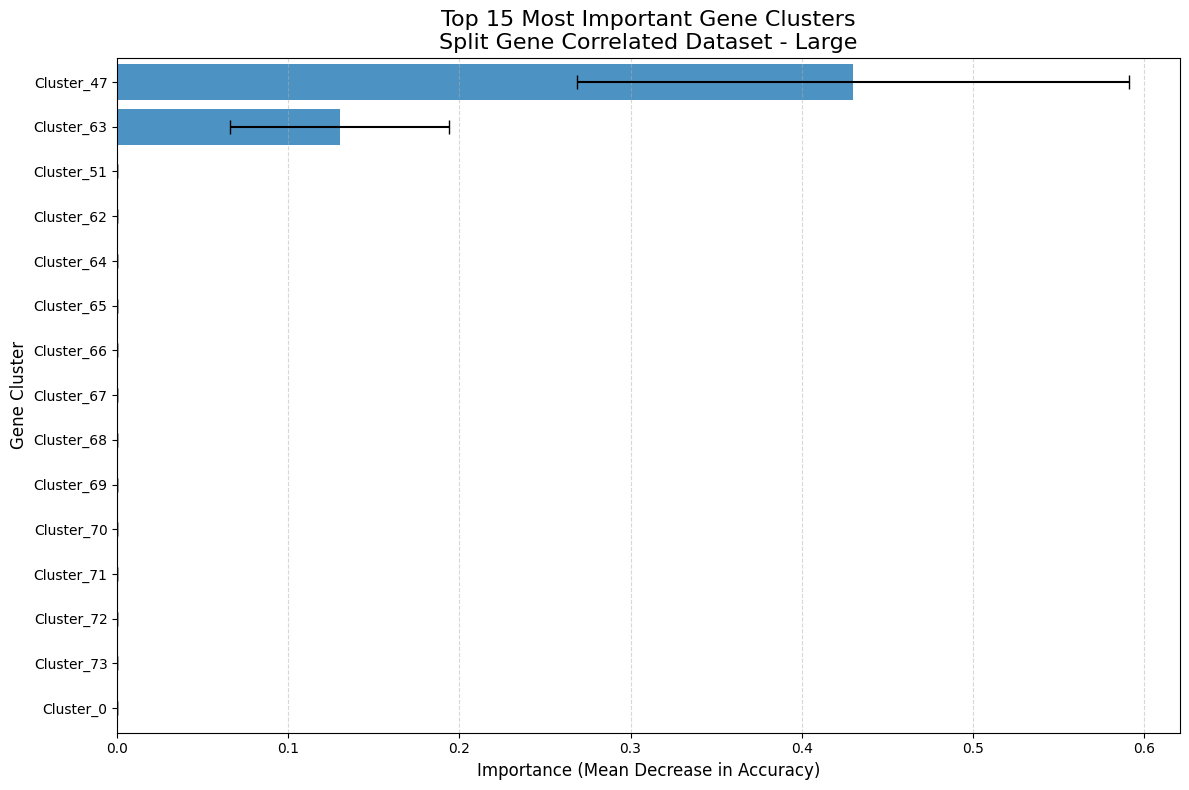


[7a] Generating FULL clustermap (100 clusters)...
Note: Ocultando etiquetas para mejor visibilidad de la estructura.
Displaying FULL clustermap (cierre la ventana para continuar)...


/home/alexbf/calmops-env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/alexbf/calmops-env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


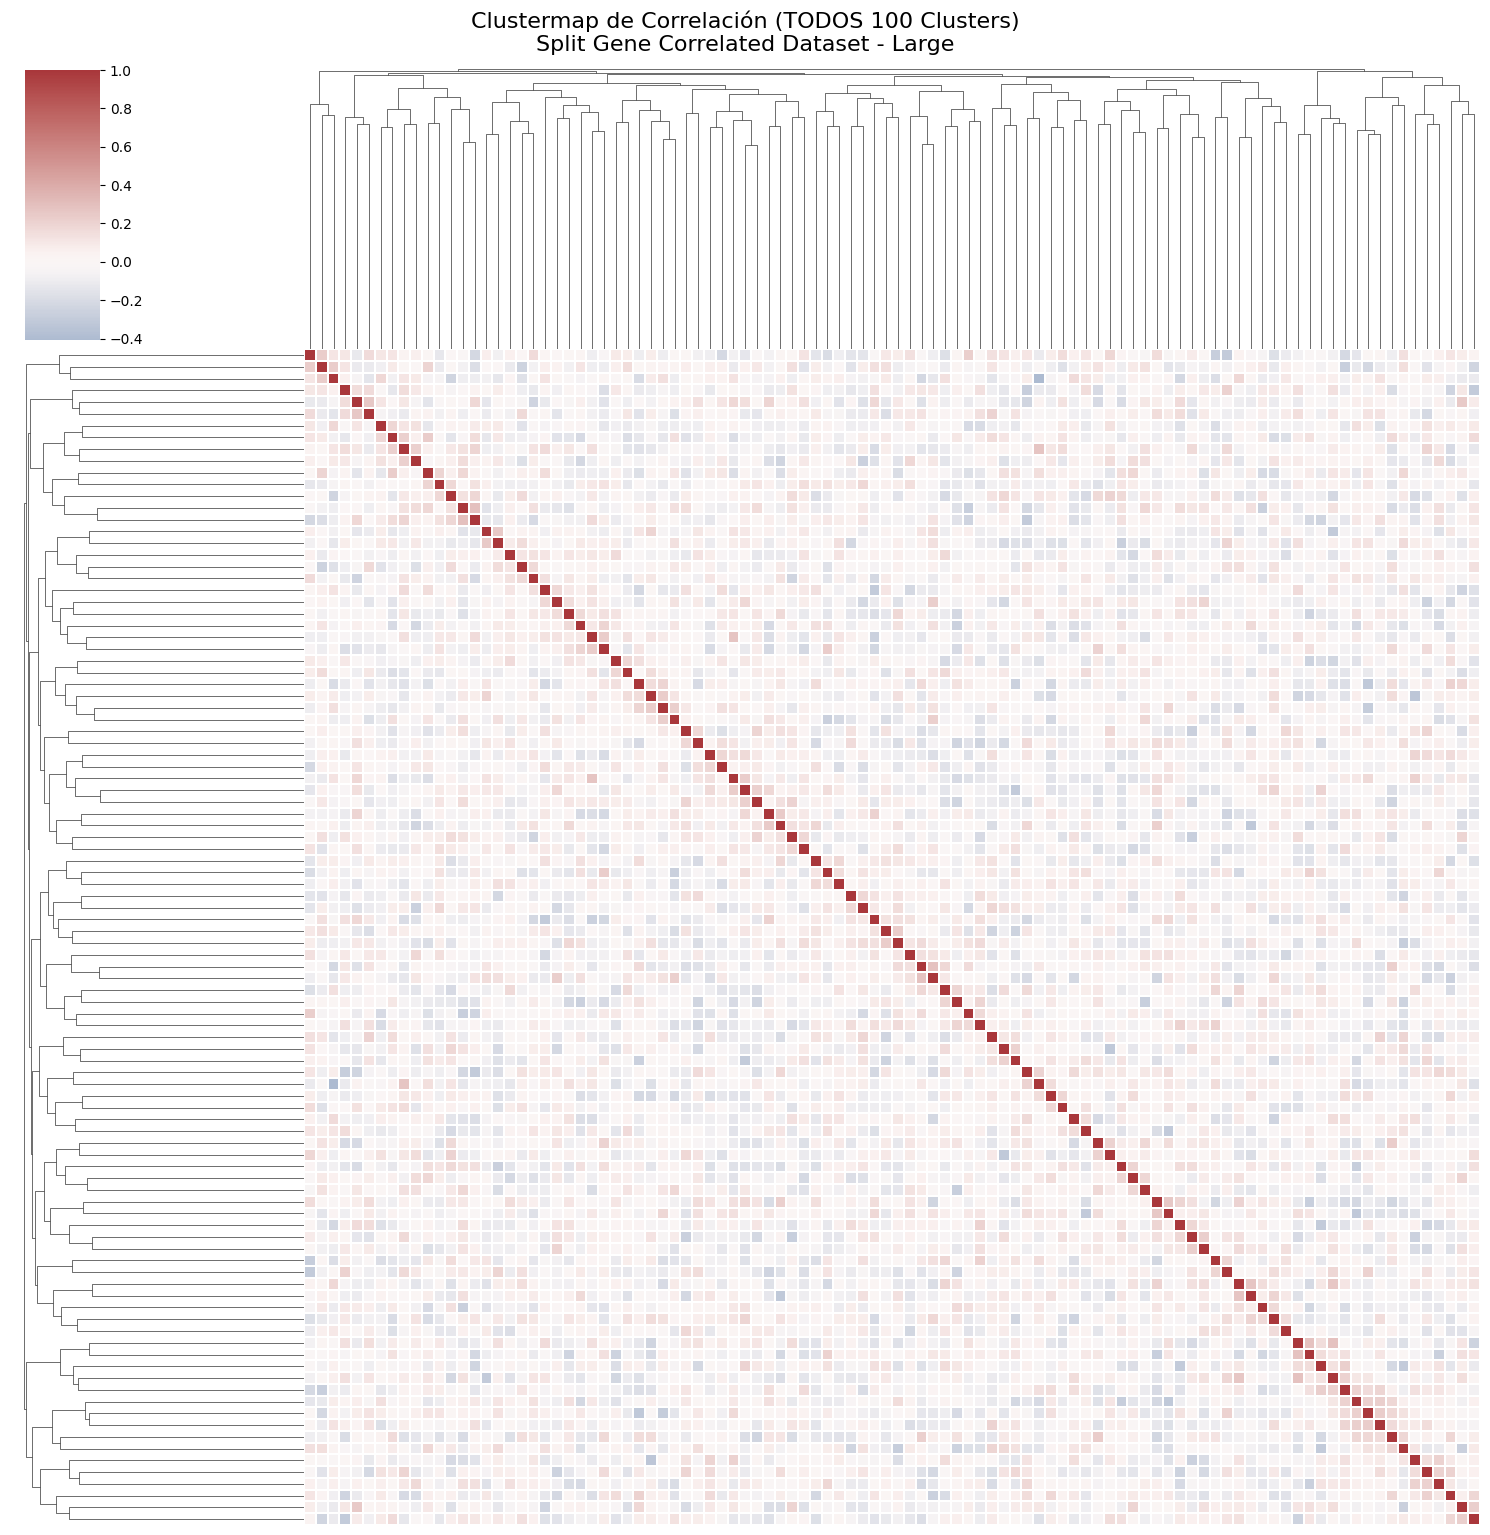


[7b] Generating TOP 15 clustermap (con etiquetas)...
Displaying TOP-K clustermap (cierre la ventana para continuar)...


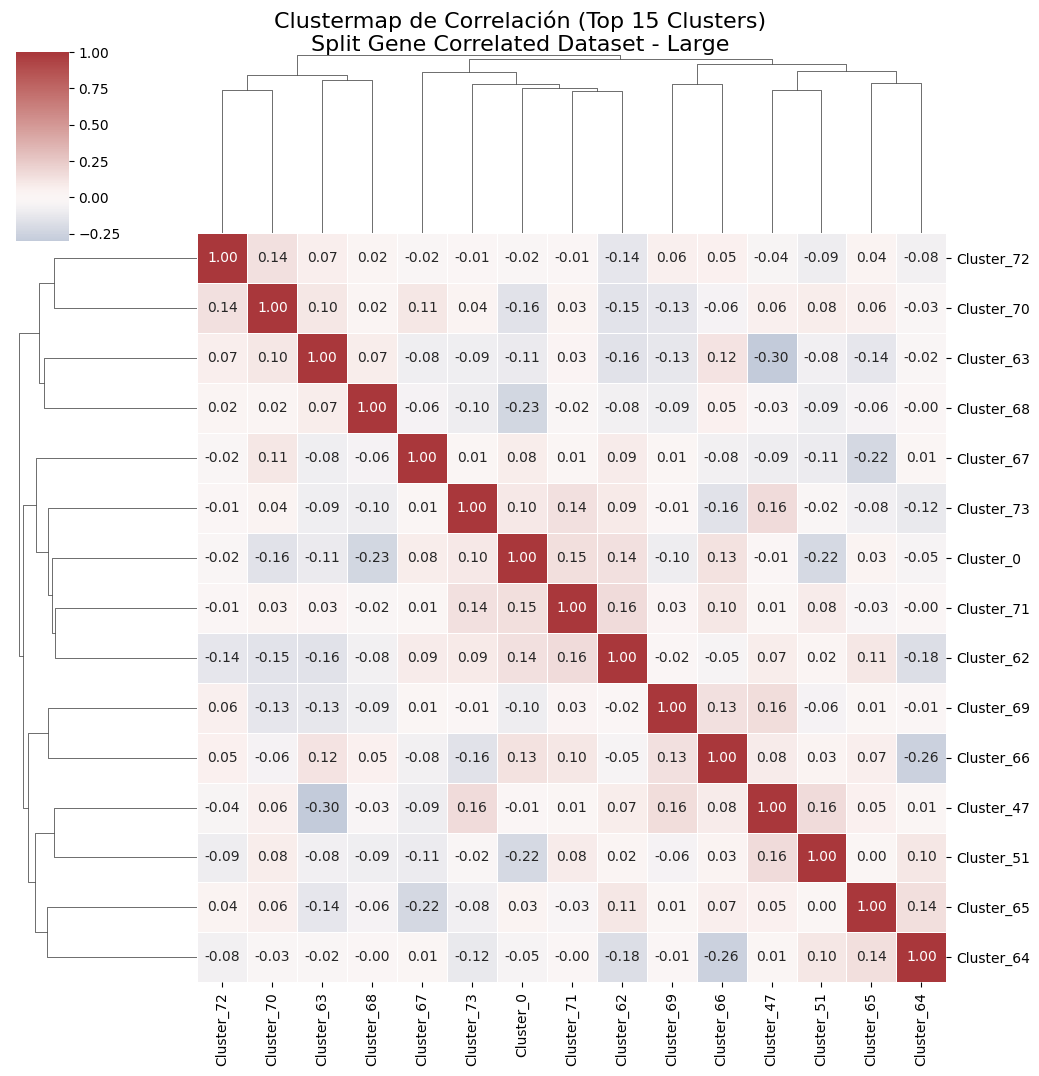

In [49]:
train_and_evaluate_cluster(df_gene, "Gene Dataset with Disease Effect - Large")
train_and_evaluate_cluster(df_minimal, "Minimal Effect Gene Dataset - Large")
train_and_evaluate_cluster(df_split, "Split Gene Correlated Dataset - Large")